In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pathlib import Path
from save_experiment import save_experiment, save_ml_experiment
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import warnings

In [35]:
df = pd.read_csv('../processed_data/hp_energy_production_with_engineered_features_1.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.dropna()

features = [
    'Water_Flow_m3_s', 'avgtempC', 'totalprecipMM', 'humidity', 'pressureMB',
    'Month', 'WaterFlow_Diff_1d', 'WaterFlow_Diff_7d', 'WaterFlow_3day_avg',
    'WaterFlow_7day_avg', 'Temp_Deviation', 'WaterFlow_Humidity',
    'month_sin', 'month_cos', 'Prev_Day_Efficiency', 'Prev_Week_Efficiency'
]
target = 'Normalized_Efficiency'

In [36]:
df_num = df.select_dtypes(include=['number']).dropna()
X = df_num.drop(columns=['Normalized_Efficiency'])
y = df_num['Normalized_Efficiency']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(n_estimators=500, max_depth=10, learning_rate=0.05, random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(n_estimators=500, depth=10, learning_rate=0.05, random_state=42, verbose=0),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=10),
    "AdaBoost": AdaBoostRegressor(random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "Multiple Linear Regression (MLR)": LinearRegression(),
    "SVR": SVR()
}

In [38]:
results = {}

for name, model in tqdm(models.items()):
    if name in ['MLP Regressor']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'Prediction': y_pred
    }

/Users/elvinanosrati/Capstone/energy-production-analysis/myenv-py311/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.58245e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [00:19<00:00,  1.37s/it]


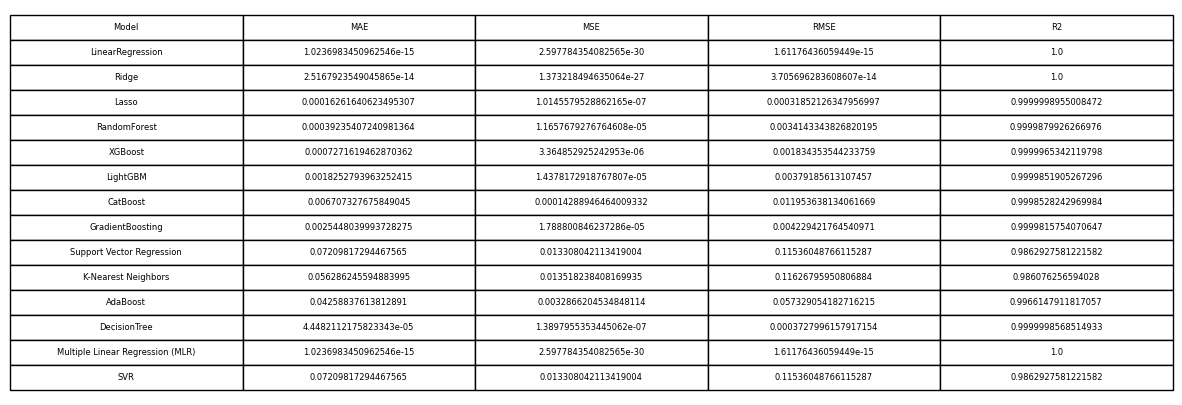

In [39]:
metrics_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MAE': [results[m]['MAE'] for m in results],
    'MSE': [results[m]['MSE'] for m in results],
    'RMSE': [results[m]['RMSE'] for m in results],
    'R2': [results[m]['R2'] for m in results]
})

table_fig, ax = plt.subplots(figsize=(10,5))
ax.axis('off')
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1.5, 1.5)
plt.show()
plt.close()

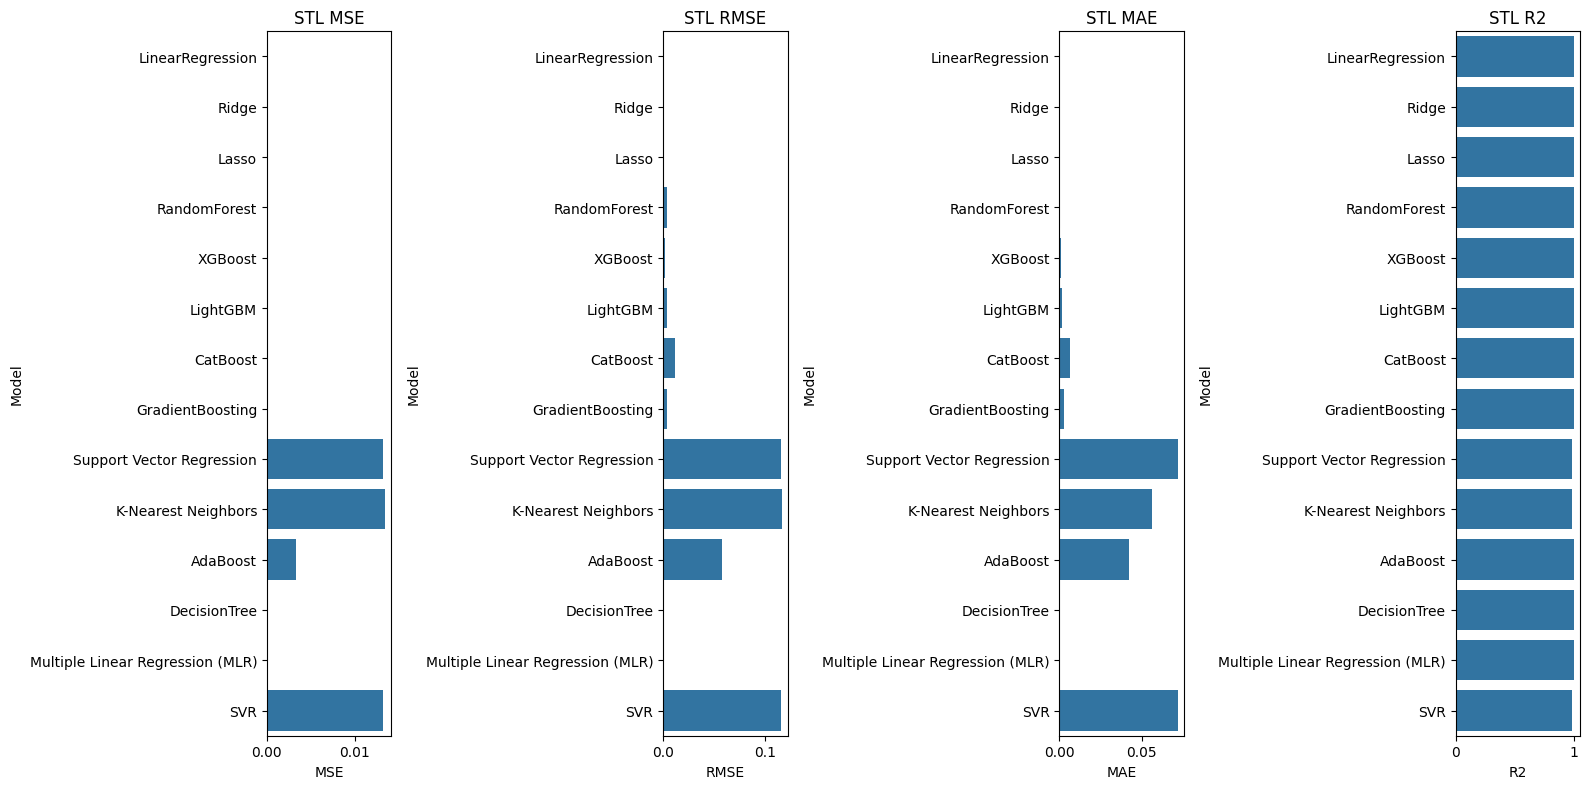

In [40]:
barplot_fig = plt.figure(figsize=(16, 8))
for i, metric in enumerate(["MSE", "RMSE", "MAE", "R2"]):
    plt.subplot(1, 4, i + 1)
    sns.barplot(y="Model", x=metric, data=metrics_df)
    plt.title("STL " + metric)
    plt.tight_layout()
plt.show()
plt.close()

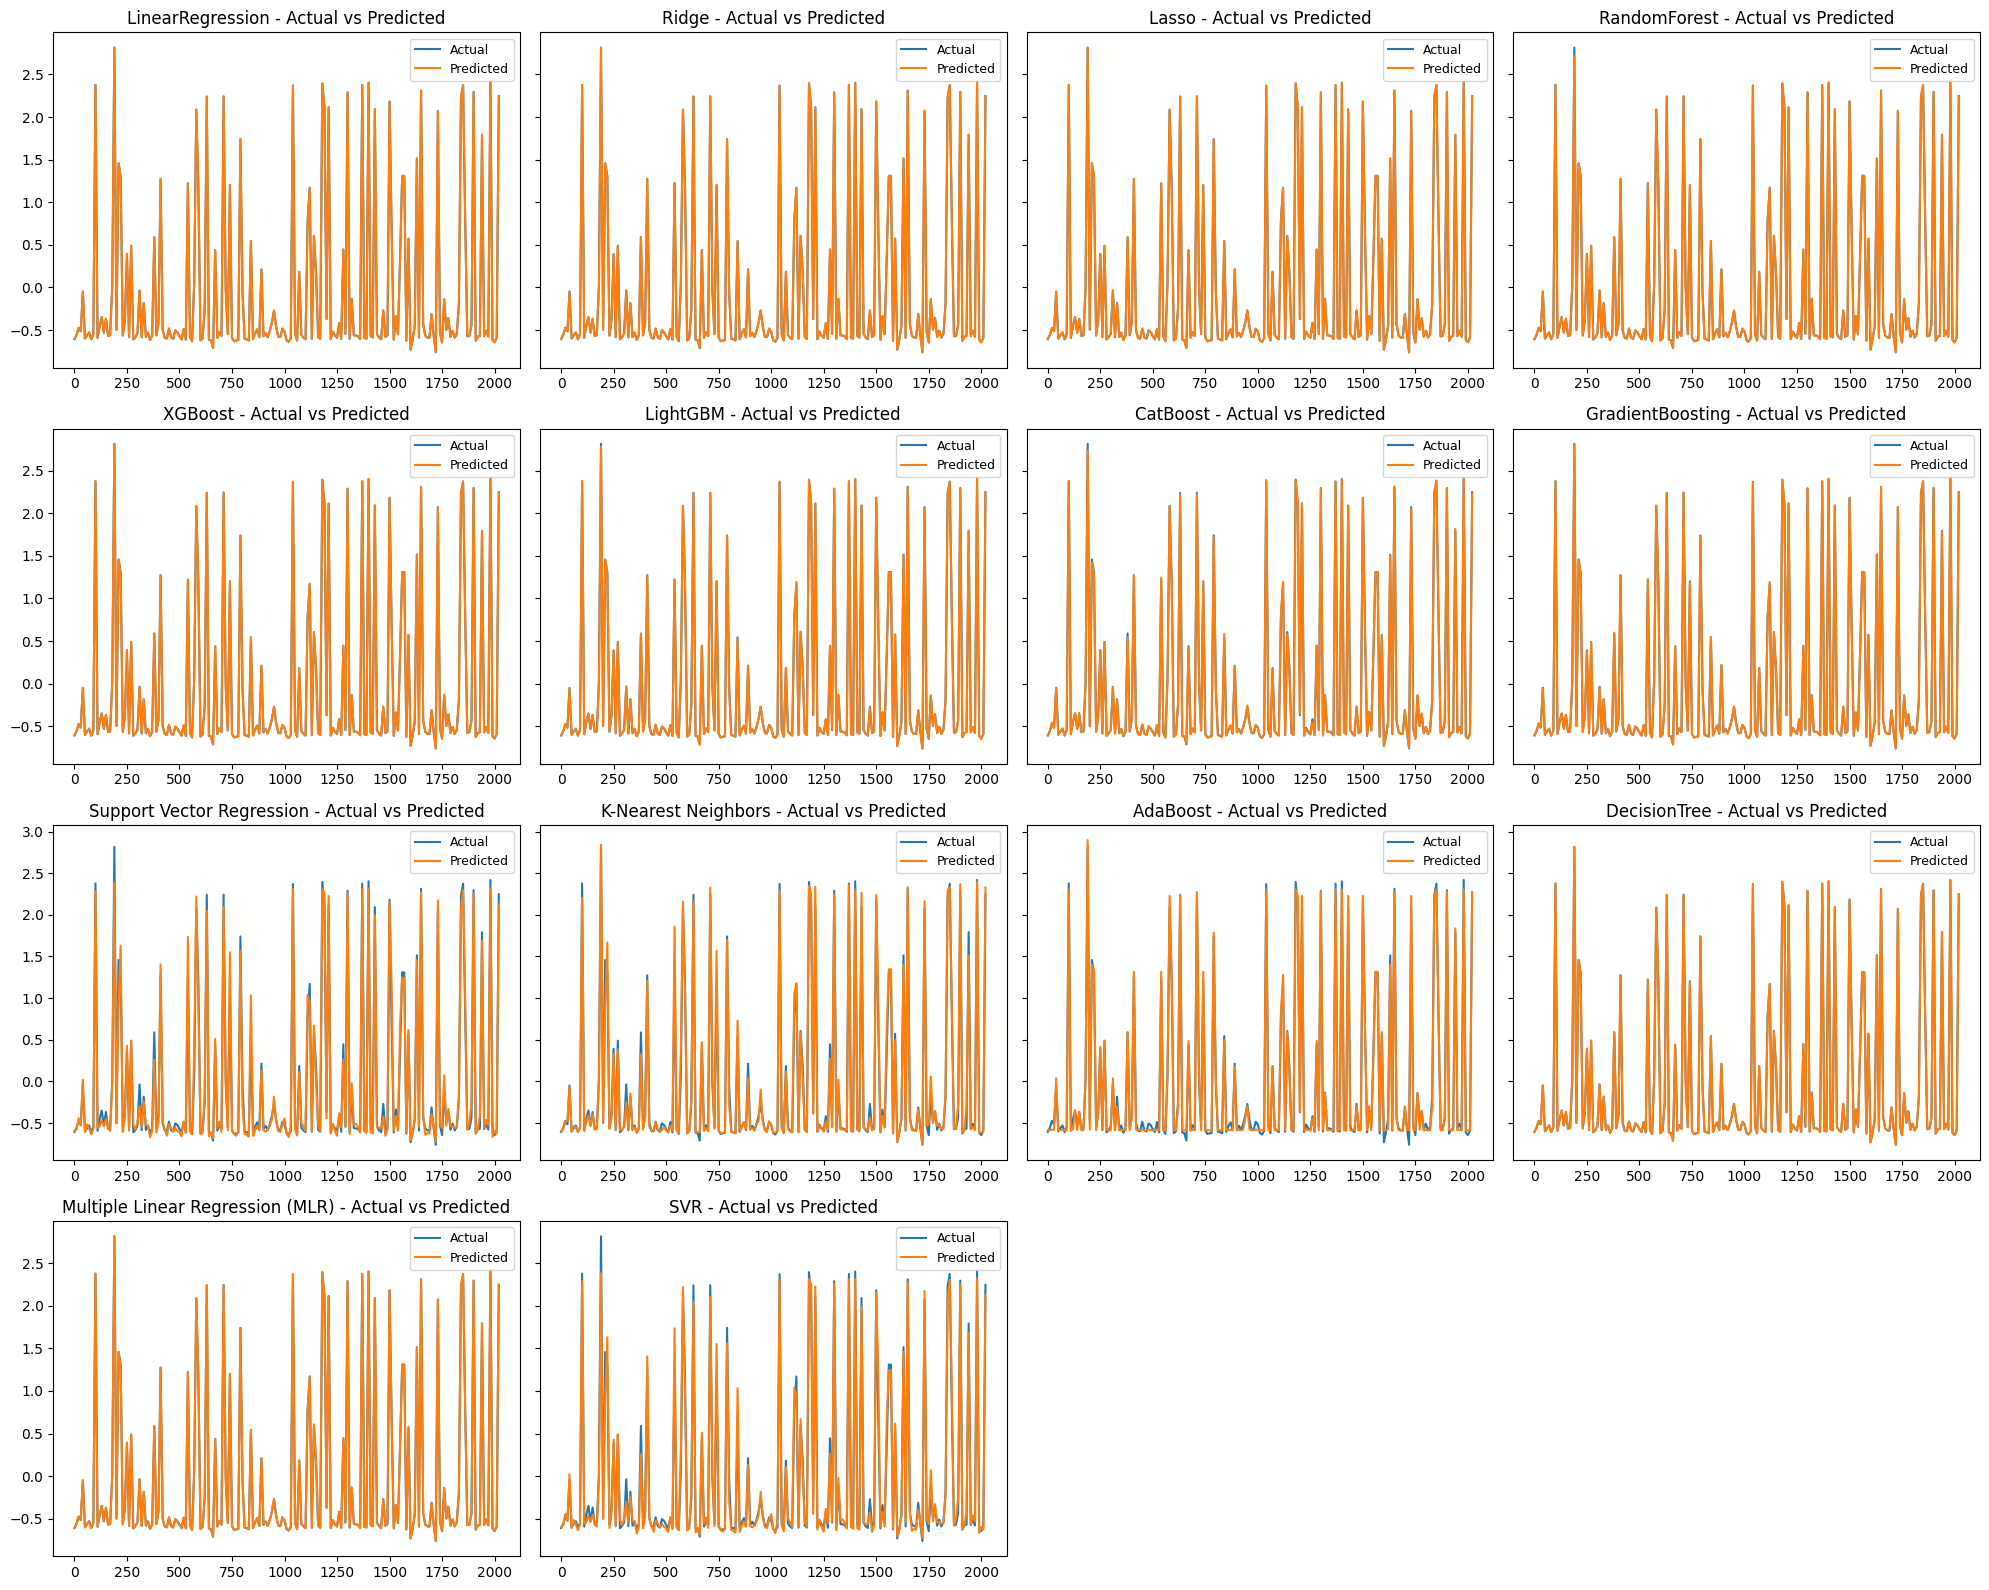

In [41]:
pred_figs = {}
cols_stl = 4
num_models_stl = len(results)
rows_stl = int(np.ceil(num_models_stl / cols_stl))
idx = np.arange(len(y_test))[::10]

fig, axes = plt.subplots(rows_stl, cols_stl, figsize=(20, 16), sharey='row')
axes = axes.flatten()

for i, (name, res) in enumerate(results.items()):
    ax = axes[i]
    ax.plot(idx, y_test.values[idx],        label='Actual')
    ax.plot(idx, res['Prediction'][idx],    label='Predicted')
    ax.set_title(f"{name} - Actual vs Predicted")
    ax.legend(fontsize=9, loc="upper right")

for j in range(len(results), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figs["AllModels"] = fig
plt.show()
plt.close()

In [9]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

X_train_tensor           = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor            = torch.tensor(X_test_scaled,  dtype=torch.float32)
X_train_tensor_tabular = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor_tabular  = torch.tensor(X_test_scaled,  dtype=torch.float32)
y_train_tensor           = torch.tensor(y_train.values,    dtype=torch.float32).view(-1, 1)
y_test_tensor            = torch.tensor(y_test.values,     dtype=torch.float32).view(-1, 1)

train_dataset            = TensorDataset(X_train_tensor,        y_train_tensor)
test_dataset             = TensorDataset(X_test_tensor,         y_test_tensor)  

train_dataset_tabular    = TensorDataset(X_train_tensor_tabular, y_train_tensor)
test_dataset_tabular     = TensorDataset(X_test_tensor_tabular,  y_test_tensor)

train_loader             = DataLoader(train_dataset,          batch_size=64,  shuffle=True)
test_loader              = DataLoader(test_dataset,           batch_size=64,  shuffle=False)
train_loader_tabular     = DataLoader(train_dataset_tabular,  batch_size=256, shuffle=True)
test_loader_tabular      = DataLoader(test_dataset_tabular,   batch_size=256, shuffle=False)

In [10]:
def reshape_input(model, xb):
    rnn_models = (LSTMNet, BiLSTMNet, RNNNet, GRUNet, CNNLSTM, DeepLSTMNet, Seq2SeqLSTM, CNNBiLSTM, GRUCNN)
    cnn_models = (CNN1D, CNNLSTM, CNNBiLSTM, GRUCNN)
    tcn_models = (TCN, TCNLSTM)

    if isinstance(model, tcn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(-1)
            xb = xb.transpose(1, 2)
    elif isinstance(model, rnn_models + cnn_models):
        if xb.dim() == 2:
            xb = xb.unsqueeze(1)
    return xb

In [11]:
class Net1(nn.Module):
    def __init__(self, input_dim):
        super(Net1, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net2(nn.Module):
    def __init__(self, input_dim):
        super(Net2, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


class Net3(nn.Module):
    def __init__(self, input_dim):
        super(Net3, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

class Net4(nn.Module):
    def __init__(self, input_dim):
        super(Net4, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),

            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)

In [12]:
class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class BiLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(BiLSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers,
                            dropout=dropout, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(hidden_dim * 2, 1)
        )

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])


class RNNNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(RNNNet, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.rnn(x)
        return self.fc(out[:, -1, :])


class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(input_size=input_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        return self.fc(out[:, -1, :])

class CNN1D(nn.Module):
    def __init__(self, input_dim, num_filters, num_layers, kernel_size, dropout):
        super().__init__()
        layers = []
        in_ch = input_dim
        for _ in range(num_layers):
            layers += [
                nn.Conv1d(in_ch, num_filters, kernel_size, padding=kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = num_filters
        self.features = nn.Sequential(*layers)
        self.fc = nn.Linear(num_filters, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        out = self.features(x)
        out = out.mean(dim=2)
        return self.fc(out)


class CNNLSTM(nn.Module):
    def __init__(
        self,
        input_dim: int,
        cnn_filters: list[int] = [64, 64],
        cnn_kernel_size: int = 3,
        lstm_hidden: int = 128,
        lstm_layers: int = 2,
        dropout: float = 0.3
    ):
        super().__init__()
        if isinstance(cnn_filters, int):
            cnn_filters = [cnn_filters]
        convs, in_ch = [], 1
        for out_ch in cnn_filters:
            convs += [
                nn.Conv1d(in_ch, out_ch, kernel_size=cnn_kernel_size,
                          padding=cnn_kernel_size//2),
                nn.ReLU(),
                nn.Dropout(dropout)
            ]
            in_ch = out_ch
        self.cnn = nn.Sequential(*convs)
        self.lstm = nn.LSTM(
            input_size=in_ch,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            dropout=dropout if lstm_layers > 1 else 0.0
        )
        self.head = nn.Linear(lstm_hidden, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if x.dim() == 4:
            x = x.squeeze(1)

        if x.dim() == 2:
            b, f = x.shape
            x = x.unsqueeze(1)       
            x = self.cnn(x)          
            x = x.transpose(1, 2)     
            out, _ = self.lstm(x)     
            return self.head(out[:, -1, :])

        elif x.dim() == 3:
            b, s, f = x.shape
            x = x.reshape(b * s, f).unsqueeze(1)  
            x = self.cnn(x)                      
            x = x.mean(dim=2)                     
            x = x.view(b, s, -1)                  
            out, _ = self.lstm(x)                 
            return self.head(out[:, -1, :])

        else:
            raise ValueError(f"Unsupported input dims: {x.dim()}")


class FNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

class DeepFNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

class DeepLSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=4, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               stride=stride, padding=padding, dilation=dilation)

        self.downsample = (nn.Conv1d(in_channels, out_channels, 1)
                           if in_channels != out_channels else None)
        self.relu = nn.ReLU()

    def forward(self, x):
        L = x.size(2) 
        out = self.conv1(x)[..., :L]    
        out = self.bn1(out); out = self.relu(out); out = self.dropout1(out)

        out = self.conv2(out)[..., :L]
        out = self.bn2(out); out = self.relu(out); out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)


class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride, dilation, dropout):
        super().__init__()
        padding = (kernel_size - 1) * dilation // 2

        self.conv1 = nn.Conv1d(
            in_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn1      = nn.BatchNorm1d(out_channels)
        self.relu1    = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(
            out_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation
        )
        self.bn2      = nn.BatchNorm1d(out_channels)
        self.relu2    = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = (
            nn.Conv1d(in_channels, out_channels, 1)
            if in_channels != out_channels else None
        )
        self.final_relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.final_relu(out + res)


class TCN(nn.Module):
    def __init__(self, input_dim, num_channels, kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        for i, out_ch in enumerate(num_channels):
            in_ch   = input_dim if i == 0 else num_channels[i-1]
            dilation = 2 ** i
            layers.append(
                TemporalBlock(
                    in_channels=in_ch,
                    out_channels=out_ch,
                    kernel_size=kernel_size,
                    stride=1,
                    dilation=dilation,
                    dropout=dropout
                )
            )
        self.network = nn.Sequential(*layers)
        self.fc      = nn.Linear(num_channels[-1], 1)

    def forward(self, x):
        x = x.transpose(1, 2)     
        y = self.network(x)       
        y = y[:, :, -1]           
        return self.fc(y)    

class CNNBiLSTM(nn.Module):
    def __init__(self, input_dim, cnn_filters=32, lstm_hidden=64, lstm_layers=2, dropout=0.3):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(input_dim, cnn_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.bilstm = nn.LSTM(
            input_size=cnn_filters,
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout
        )
        self.fc = nn.Linear(2 * lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.cnn(x)
        x = x.transpose(1, 2)
        out, _ = self.bilstm(x)
        return self.fc(out[:, -1, :])

class GRUCNN(nn.Module):
    def __init__(self, input_dim, gru_hidden=64, cnn_filters=32, kernel_size=3, dropout=0.3):
        super().__init__()
        self.gru = nn.GRU(input_dim, gru_hidden, batch_first=True)
        self.cnn = nn.Sequential(
            nn.Conv1d(gru_hidden, cnn_filters, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.fc = nn.Linear(cnn_filters, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.cnn(out.transpose(1, 2))
        out = out.mean(dim=2)
        return self.fc(out)

class TCNLSTM(nn.Module):
    def __init__(self, input_dim, tcn_channels=[64,64], lstm_hidden=64, lstm_layers=1, kernel_size=3, dropout=0.3):
        super().__init__()
        self.tcn = TCN(input_dim, tcn_channels, kernel_size=kernel_size, dropout=dropout)
        self.lstm = nn.LSTM(input_size=tcn_channels[-1], hidden_size=lstm_hidden, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden, 1)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.tcn.network(x).transpose(1, 2)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class Seq2SeqLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2, dropout=0.3):
        super(Seq2SeqLSTM, self).__init__()
        self.encoder = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, hidden_dim, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (hidden, cell) = self.encoder(x)
        dec_input = torch.zeros(x.size(0), 1, hidden.size(2)).to(x.device)
        out, _ = self.decoder(dec_input, (hidden, cell))
        return self.fc(out[:, -1, :])
  

In [13]:
def train_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor,epochs=1000, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    history = []
    for epoch in tqdm(range(1, epochs + 1)):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        
        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train_tensor)
            y_test_pred  = model(X_test_tensor)

            train_mse  = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mse   = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_rmse = np.sqrt(train_mse)
            test_rmse  = np.sqrt(test_mse)
            train_mae  = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mae   = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_r2   = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
            test_r2    = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

            history.append({
                "Model": name,
                "Epoch": epoch,
                "Train MSE": train_mse,
                "Test MSE": test_mse,
                "Train RMSE": train_rmse,
                "Test RMSE": test_rmse,
                "Train MAE": train_mae,
                "Test MAE": test_mae,
                "Train R2": train_r2,
                "Test R2": test_r2
            })

            if epoch % 10 == 0 or epoch == 1 or epoch == epochs:
                print(f"\nModel: {name} | Epoch: {epoch}/{epochs}")
                print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
                print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")
                
    return history

In [14]:
def train_ts_model(name, model, train_loader, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs=200, lr=1e-3):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    history = []
    for epoch in tqdm(range(1, epochs + 1), desc=f"Training {name}"):
        model.train()
        running_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()    
            running_loss += loss.item()

        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train_tensor)
            y_test_pred  = model(X_test_tensor)

            train_mse = mean_squared_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mse  = mean_squared_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_rmse = np.sqrt(train_mse)
            test_rmse  = np.sqrt(test_mse)
            train_mae = mean_absolute_error(y_train_tensor.numpy(), y_train_pred.numpy())
            test_mae  = mean_absolute_error(y_test_tensor.numpy(), y_test_pred.numpy())
            train_r2  = r2_score(y_train_tensor.numpy(), y_train_pred.numpy())
            test_r2   = r2_score(y_test_tensor.numpy(), y_test_pred.numpy())

            history.append({
                "Model": name,
                "Epoch": epoch,
                "Train MSE": train_mse,
                "Test MSE": test_mse,
                "Train RMSE": train_rmse,
                "Test RMSE": test_rmse,
                "Train MAE": train_mae,
                "Test MAE": test_mae,
                "Train R2": train_r2,
                "Test R2": test_r2
            })

            if epoch % 10 == 0 or epoch == 1 or epoch == epochs:
                print(f"\nModel: {name} | Epoch: {epoch}/{epochs}")
                print(f"Train: MSE: {train_mse:.4f}, RMSE: {train_rmse:.4f}, MAE: {train_mae:.4f}, R2: {train_r2:.4f}")
                print(f"Test:  MSE: {test_mse:.4f}, RMSE: {test_rmse:.4f}, MAE: {test_mae:.4f}, R2: {test_r2:.4f}")

    return history

In [15]:
input_dim = X_test_tensor_tabular.shape[1]

nets = {
    "Net1":   Net1(input_dim),
    "Net2":   Net2(input_dim),
    "Net3":   Net3(input_dim),
    "Net4":   Net4(input_dim)
}

nets_tabular = {
    "Net1":    Net1(input_dim),
    "Net2":    Net2(input_dim),
    "Net3":    Net3(input_dim),
    "Net4":    Net4(input_dim),
    "FNN":     FNN(input_dim),
    "DeepFNN": DeepFNN(input_dim)
}

In [16]:
results = []
for name, net in nets.items():
    results += train_model(name, net, train_loader, 
                               X_train_tensor, y_train_tensor, 
                               X_test_tensor, y_test_tensor,
                               epochs=100, lr=1e-3)
    
nn_metrics_df = pd.DataFrame(results)

  3%|███                                                                                                    | 3/100 [00:00<00:07, 12.38it/s]


Model: Net1 | Epoch: 1/100
Train: MSE: 0.0067, RMSE: 0.0817, MAE: 0.0577, R2: 0.9934
Test:  MSE: 0.0073, RMSE: 0.0857, MAE: 0.0608, R2: 0.9924


 13%|█████████████▎                                                                                        | 13/100 [00:00<00:05, 14.52it/s]


Model: Net1 | Epoch: 10/100
Train: MSE: 0.0003, RMSE: 0.0175, MAE: 0.0123, R2: 0.9997
Test:  MSE: 0.0003, RMSE: 0.0182, MAE: 0.0128, R2: 0.9997


 23%|███████████████████████▍                                                                              | 23/100 [00:01<00:05, 14.45it/s]


Model: Net1 | Epoch: 20/100
Train: MSE: 0.0002, RMSE: 0.0125, MAE: 0.0089, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0140, MAE: 0.0097, R2: 0.9998


 31%|███████████████████████████████▌                                                                      | 31/100 [00:02<00:04, 14.59it/s]


Model: Net1 | Epoch: 30/100
Train: MSE: 0.0001, RMSE: 0.0097, MAE: 0.0071, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0117, MAE: 0.0080, R2: 0.9999


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:02<00:04, 14.15it/s]


Model: Net1 | Epoch: 40/100
Train: MSE: 0.0001, RMSE: 0.0099, MAE: 0.0072, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0113, MAE: 0.0079, R2: 0.9999


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:03<00:03, 14.59it/s]


Model: Net1 | Epoch: 50/100
Train: MSE: 0.0000, RMSE: 0.0070, MAE: 0.0052, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0084, MAE: 0.0058, R2: 0.9999


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:04<00:02, 14.09it/s]


Model: Net1 | Epoch: 60/100
Train: MSE: 0.0001, RMSE: 0.0087, MAE: 0.0069, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0098, MAE: 0.0075, R2: 0.9999


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:05<00:02, 14.05it/s]


Model: Net1 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0092, MAE: 0.0072, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0098, MAE: 0.0076, R2: 0.9999


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:05<00:01, 13.65it/s]


Model: Net1 | Epoch: 80/100
Train: MSE: 0.0000, RMSE: 0.0056, MAE: 0.0042, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0069, MAE: 0.0047, R2: 1.0000


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:06<00:00, 13.63it/s]


Model: Net1 | Epoch: 90/100
Train: MSE: 0.0000, RMSE: 0.0060, MAE: 0.0047, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0067, MAE: 0.0050, R2: 1.0000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.97it/s]



Model: Net1 | Epoch: 100/100
Train: MSE: 0.0000, RMSE: 0.0041, MAE: 0.0030, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0056, MAE: 0.0036, R2: 1.0000


  1%|█                                                                                                      | 1/100 [00:00<00:16,  6.13it/s]


Model: Net2 | Epoch: 1/100
Train: MSE: 0.0021, RMSE: 0.0463, MAE: 0.0330, R2: 0.9979
Test:  MSE: 0.0024, RMSE: 0.0487, MAE: 0.0344, R2: 0.9976


 11%|███████████▏                                                                                          | 11/100 [00:01<00:10,  8.34it/s]


Model: Net2 | Epoch: 10/100
Train: MSE: 0.0002, RMSE: 0.0125, MAE: 0.0091, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0147, MAE: 0.0100, R2: 0.9998


 21%|█████████████████████▍                                                                                | 21/100 [00:02<00:08,  9.08it/s]


Model: Net2 | Epoch: 20/100
Train: MSE: 0.0002, RMSE: 0.0126, MAE: 0.0110, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0141, MAE: 0.0116, R2: 0.9998


 31%|███████████████████████████████▌                                                                      | 31/100 [00:03<00:07,  9.12it/s]


Model: Net2 | Epoch: 30/100
Train: MSE: 0.0001, RMSE: 0.0089, MAE: 0.0068, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0105, MAE: 0.0075, R2: 0.9999


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:04<00:06,  8.49it/s]


Model: Net2 | Epoch: 40/100
Train: MSE: 0.0003, RMSE: 0.0175, MAE: 0.0105, R2: 0.9997
Test:  MSE: 0.0003, RMSE: 0.0182, MAE: 0.0110, R2: 0.9997


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:05<00:05,  8.69it/s]


Model: Net2 | Epoch: 50/100
Train: MSE: 0.0000, RMSE: 0.0065, MAE: 0.0050, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0076, MAE: 0.0054, R2: 0.9999


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:07<00:04,  8.55it/s]


Model: Net2 | Epoch: 60/100
Train: MSE: 0.0000, RMSE: 0.0048, MAE: 0.0034, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0056, MAE: 0.0038, R2: 1.0000


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:08<00:03,  8.67it/s]


Model: Net2 | Epoch: 70/100
Train: MSE: 0.0000, RMSE: 0.0040, MAE: 0.0031, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0052, MAE: 0.0036, R2: 1.0000


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:09<00:02,  8.90it/s]


Model: Net2 | Epoch: 80/100
Train: MSE: 0.0000, RMSE: 0.0050, MAE: 0.0036, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0057, MAE: 0.0040, R2: 1.0000


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:10<00:00,  9.30it/s]


Model: Net2 | Epoch: 90/100
Train: MSE: 0.0000, RMSE: 0.0044, MAE: 0.0031, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0052, MAE: 0.0036, R2: 1.0000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.73it/s]



Model: Net2 | Epoch: 100/100
Train: MSE: 0.0001, RMSE: 0.0074, MAE: 0.0062, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0076, MAE: 0.0063, R2: 0.9999


  1%|█                                                                                                      | 1/100 [00:00<00:17,  5.67it/s]


Model: Net3 | Epoch: 1/100
Train: MSE: 0.0011, RMSE: 0.0335, MAE: 0.0240, R2: 0.9989
Test:  MSE: 0.0012, RMSE: 0.0343, MAE: 0.0249, R2: 0.9988


 11%|███████████▏                                                                                          | 11/100 [00:01<00:13,  6.46it/s]


Model: Net3 | Epoch: 10/100
Train: MSE: 0.0001, RMSE: 0.0085, MAE: 0.0059, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0100, MAE: 0.0063, R2: 0.9999


 21%|█████████████████████▍                                                                                | 21/100 [00:03<00:12,  6.34it/s]


Model: Net3 | Epoch: 20/100
Train: MSE: 0.0001, RMSE: 0.0099, MAE: 0.0085, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0115, MAE: 0.0090, R2: 0.9999


 31%|███████████████████████████████▌                                                                      | 31/100 [00:04<00:10,  6.51it/s]


Model: Net3 | Epoch: 30/100
Train: MSE: 0.0001, RMSE: 0.0080, MAE: 0.0064, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0097, MAE: 0.0070, R2: 0.9999


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:06<00:09,  5.99it/s]


Model: Net3 | Epoch: 40/100
Train: MSE: 0.0001, RMSE: 0.0102, MAE: 0.0085, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0110, MAE: 0.0088, R2: 0.9999


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:08<00:08,  6.08it/s]


Model: Net3 | Epoch: 50/100
Train: MSE: 0.0001, RMSE: 0.0097, MAE: 0.0071, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0111, MAE: 0.0076, R2: 0.9999


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:09<00:06,  5.95it/s]


Model: Net3 | Epoch: 60/100
Train: MSE: 0.0001, RMSE: 0.0076, MAE: 0.0056, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0085, MAE: 0.0060, R2: 0.9999


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:11<00:04,  6.34it/s]


Model: Net3 | Epoch: 70/100
Train: MSE: 0.0006, RMSE: 0.0240, MAE: 0.0153, R2: 0.9994
Test:  MSE: 0.0006, RMSE: 0.0240, MAE: 0.0154, R2: 0.9994


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:12<00:02,  7.86it/s]


Model: Net3 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0084, MAE: 0.0049, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0089, MAE: 0.0051, R2: 0.9999


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:13<00:01,  8.09it/s]


Model: Net3 | Epoch: 90/100
Train: MSE: 0.0000, RMSE: 0.0043, MAE: 0.0035, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0051, MAE: 0.0039, R2: 1.0000


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.68it/s]



Model: Net3 | Epoch: 100/100
Train: MSE: 0.0000, RMSE: 0.0034, MAE: 0.0025, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0042, MAE: 0.0029, R2: 1.0000


  1%|█                                                                                                      | 1/100 [00:00<00:26,  3.80it/s]


Model: Net4 | Epoch: 1/100
Train: MSE: 0.0035, RMSE: 0.0588, MAE: 0.0466, R2: 0.9966
Test:  MSE: 0.0036, RMSE: 0.0596, MAE: 0.0471, R2: 0.9963


 10%|██████████▏                                                                                           | 10/100 [00:02<00:23,  3.81it/s]


Model: Net4 | Epoch: 10/100
Train: MSE: 0.0030, RMSE: 0.0544, MAE: 0.0422, R2: 0.9971
Test:  MSE: 0.0034, RMSE: 0.0580, MAE: 0.0433, R2: 0.9965


 20%|████████████████████▍                                                                                 | 20/100 [00:05<00:21,  3.78it/s]


Model: Net4 | Epoch: 20/100
Train: MSE: 0.0101, RMSE: 0.1005, MAE: 0.0631, R2: 0.9900
Test:  MSE: 0.0098, RMSE: 0.0992, MAE: 0.0620, R2: 0.9899


 30%|██████████████████████████████▌                                                                       | 30/100 [00:08<00:26,  2.65it/s]


Model: Net4 | Epoch: 30/100
Train: MSE: 0.0062, RMSE: 0.0790, MAE: 0.0596, R2: 0.9938
Test:  MSE: 0.0065, RMSE: 0.0805, MAE: 0.0602, R2: 0.9933


 40%|████████████████████████████████████████▊                                                             | 40/100 [00:10<00:16,  3.69it/s]


Model: Net4 | Epoch: 40/100
Train: MSE: 0.0061, RMSE: 0.0784, MAE: 0.0524, R2: 0.9939
Test:  MSE: 0.0063, RMSE: 0.0791, MAE: 0.0526, R2: 0.9936


 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:13<00:13,  3.82it/s]


Model: Net4 | Epoch: 50/100
Train: MSE: 0.0102, RMSE: 0.1012, MAE: 0.0585, R2: 0.9898
Test:  MSE: 0.0100, RMSE: 0.1001, MAE: 0.0585, R2: 0.9897


 60%|█████████████████████████████████████████████████████████████▏                                        | 60/100 [00:16<00:11,  3.61it/s]


Model: Net4 | Epoch: 60/100
Train: MSE: 0.0109, RMSE: 0.1045, MAE: 0.0675, R2: 0.9892
Test:  MSE: 0.0106, RMSE: 0.1028, MAE: 0.0662, R2: 0.9891


 70%|███████████████████████████████████████████████████████████████████████▍                              | 70/100 [00:21<00:15,  1.92it/s]


Model: Net4 | Epoch: 70/100
Train: MSE: 0.0101, RMSE: 0.1006, MAE: 0.0513, R2: 0.9900
Test:  MSE: 0.0096, RMSE: 0.0982, MAE: 0.0503, R2: 0.9901


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [00:33<00:37,  1.85s/it]


Model: Net4 | Epoch: 80/100
Train: MSE: 0.0139, RMSE: 0.1180, MAE: 0.0648, R2: 0.9862
Test:  MSE: 0.0133, RMSE: 0.1153, MAE: 0.0637, R2: 0.9863


 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 90/100 [00:43<00:08,  1.13it/s]


Model: Net4 | Epoch: 90/100
Train: MSE: 0.0090, RMSE: 0.0948, MAE: 0.0589, R2: 0.9911
Test:  MSE: 0.0086, RMSE: 0.0926, MAE: 0.0572, R2: 0.9912


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.82it/s]


Model: Net4 | Epoch: 100/100
Train: MSE: 0.0185, RMSE: 0.1359, MAE: 0.0682, R2: 0.9817
Test:  MSE: 0.0176, RMSE: 0.1325, MAE: 0.0669, R2: 0.9819


In [17]:
results_tabular = []
for name, net in nets_tabular.items():
    results_tabular += train_model(
        name, net, train_loader_tabular,
        X_train_tensor_tabular, y_train_tensor,
        X_test_tensor_tabular,  y_test_tensor,
        epochs=100, lr=1e-3
    )
nn_metrics_df_tabular = pd.DataFrame(results_tabular)

  2%|██                                                                                                     | 2/100 [00:00<00:25,  3.81it/s]


Model: Net1 | Epoch: 1/100
Train: MSE: 0.2547, RMSE: 0.5047, MAE: 0.3179, R2: 0.7473
Test:  MSE: 0.2423, RMSE: 0.4922, MAE: 0.3088, R2: 0.7504


 13%|█████████████▎                                                                                        | 13/100 [00:01<00:05, 14.67it/s]


Model: Net1 | Epoch: 10/100
Train: MSE: 0.0017, RMSE: 0.0410, MAE: 0.0302, R2: 0.9983
Test:  MSE: 0.0019, RMSE: 0.0440, MAE: 0.0317, R2: 0.9980


 23%|███████████████████████▍                                                                              | 23/100 [00:01<00:04, 16.64it/s]


Model: Net1 | Epoch: 20/100
Train: MSE: 0.0007, RMSE: 0.0256, MAE: 0.0186, R2: 0.9993
Test:  MSE: 0.0008, RMSE: 0.0281, MAE: 0.0198, R2: 0.9992


 33%|█████████████████████████████████▋                                                                    | 33/100 [00:02<00:04, 16.55it/s]


Model: Net1 | Epoch: 30/100
Train: MSE: 0.0004, RMSE: 0.0200, MAE: 0.0144, R2: 0.9996
Test:  MSE: 0.0005, RMSE: 0.0223, MAE: 0.0153, R2: 0.9995


 43%|███████████████████████████████████████████▊                                                          | 43/100 [00:03<00:03, 17.26it/s]


Model: Net1 | Epoch: 40/100
Train: MSE: 0.0003, RMSE: 0.0167, MAE: 0.0122, R2: 0.9997
Test:  MSE: 0.0004, RMSE: 0.0189, MAE: 0.0130, R2: 0.9996


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:03<00:02, 17.13it/s]


Model: Net1 | Epoch: 50/100
Train: MSE: 0.0002, RMSE: 0.0146, MAE: 0.0106, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0164, MAE: 0.0113, R2: 0.9997


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:04<00:02, 18.31it/s]


Model: Net1 | Epoch: 60/100
Train: MSE: 0.0002, RMSE: 0.0130, MAE: 0.0094, R2: 0.9998
Test:  MSE: 0.0002, RMSE: 0.0149, MAE: 0.0100, R2: 0.9998


 73%|██████████████████████████████████████████████████████████████████████████▍                           | 73/100 [00:05<00:01, 15.88it/s]


Model: Net1 | Epoch: 70/100
Train: MSE: 0.0001, RMSE: 0.0117, MAE: 0.0084, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0135, MAE: 0.0091, R2: 0.9998


 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 83/100 [00:05<00:00, 18.07it/s]


Model: Net1 | Epoch: 80/100
Train: MSE: 0.0001, RMSE: 0.0106, MAE: 0.0075, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0122, MAE: 0.0081, R2: 0.9998


 93%|██████████████████████████████████████████████████████████████████████████████████████████████▊       | 93/100 [00:06<00:00, 17.66it/s]


Model: Net1 | Epoch: 90/100
Train: MSE: 0.0001, RMSE: 0.0098, MAE: 0.0070, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0116, MAE: 0.0076, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.39it/s]



Model: Net1 | Epoch: 100/100
Train: MSE: 0.0001, RMSE: 0.0089, MAE: 0.0063, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0109, MAE: 0.0071, R2: 0.9999


  1%|█                                                                                                      | 1/100 [00:00<00:13,  7.40it/s]


Model: Net2 | Epoch: 1/100
Train: MSE: 0.0421, RMSE: 0.2052, MAE: 0.1416, R2: 0.9582
Test:  MSE: 0.0444, RMSE: 0.2107, MAE: 0.1444, R2: 0.9543


 12%|████████████▏                                                                                         | 12/100 [00:01<00:10,  8.19it/s]


Model: Net2 | Epoch: 10/100
Train: MSE: 0.0004, RMSE: 0.0203, MAE: 0.0144, R2: 0.9996
Test:  MSE: 0.0005, RMSE: 0.0228, MAE: 0.0154, R2: 0.9995


 21%|█████████████████████▍                                                                                | 21/100 [00:02<00:08,  9.71it/s]


Model: Net2 | Epoch: 20/100
Train: MSE: 0.0002, RMSE: 0.0140, MAE: 0.0098, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0166, MAE: 0.0108, R2: 0.9997


 31%|███████████████████████████████▌                                                                      | 31/100 [00:03<00:08,  8.27it/s]


Model: Net2 | Epoch: 30/100
Train: MSE: 0.0001, RMSE: 0.0111, MAE: 0.0080, R2: 0.9999
Test:  MSE: 0.0002, RMSE: 0.0137, MAE: 0.0089, R2: 0.9998


 43%|███████████████████████████████████████████▊                                                          | 43/100 [00:04<00:04, 12.38it/s]


Model: Net2 | Epoch: 40/100
Train: MSE: 0.0001, RMSE: 0.0092, MAE: 0.0067, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0116, MAE: 0.0076, R2: 0.9999


 53%|██████████████████████████████████████████████████████                                                | 53/100 [00:05<00:03, 15.20it/s]


Model: Net2 | Epoch: 50/100
Train: MSE: 0.0001, RMSE: 0.0081, MAE: 0.0058, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0105, MAE: 0.0067, R2: 0.9999


 63%|████████████████████████████████████████████████████████████████▎                                     | 63/100 [00:05<00:02, 15.83it/s]


Model: Net2 | Epoch: 60/100
Train: MSE: 0.0001, RMSE: 0.0071, MAE: 0.0051, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0097, MAE: 0.0061, R2: 0.9999


 73%|██████████████████████████████████████████████████████████████████████████▍                           | 73/100 [00:06<00:01, 16.44it/s]


Model: Net2 | Epoch: 70/100
Train: MSE: 0.0000, RMSE: 0.0066, MAE: 0.0048, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0095, MAE: 0.0057, R2: 0.9999


 83%|████████████████████████████████████████████████████████████████████████████████████▋                 | 83/100 [00:07<00:01, 13.87it/s]


Model: Net2 | Epoch: 80/100
Train: MSE: 0.0000, RMSE: 0.0061, MAE: 0.0047, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0089, MAE: 0.0057, R2: 0.9999


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:08<00:00,  9.93it/s]


Model: Net2 | Epoch: 90/100
Train: MSE: 0.0000, RMSE: 0.0060, MAE: 0.0045, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0087, MAE: 0.0056, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.67it/s]



Model: Net2 | Epoch: 100/100
Train: MSE: 0.0000, RMSE: 0.0067, MAE: 0.0050, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0088, MAE: 0.0058, R2: 0.9999


  2%|██                                                                                                     | 2/100 [00:00<00:08, 12.15it/s]


Model: Net3 | Epoch: 1/100
Train: MSE: 0.0123, RMSE: 0.1110, MAE: 0.0895, R2: 0.9878
Test:  MSE: 0.0128, RMSE: 0.1134, MAE: 0.0916, R2: 0.9868


 12%|████████████▏                                                                                         | 12/100 [00:00<00:06, 12.79it/s]


Model: Net3 | Epoch: 10/100
Train: MSE: 0.0002, RMSE: 0.0153, MAE: 0.0108, R2: 0.9998
Test:  MSE: 0.0003, RMSE: 0.0169, MAE: 0.0114, R2: 0.9997


 22%|██████████████████████▍                                                                               | 22/100 [00:01<00:06, 11.92it/s]


Model: Net3 | Epoch: 20/100
Train: MSE: 0.0001, RMSE: 0.0093, MAE: 0.0067, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0108, MAE: 0.0072, R2: 0.9999


 32%|████████████████████████████████▋                                                                     | 32/100 [00:02<00:05, 11.44it/s]


Model: Net3 | Epoch: 30/100
Train: MSE: 0.0001, RMSE: 0.0084, MAE: 0.0064, R2: 0.9999
Test:  MSE: 0.0001, RMSE: 0.0104, MAE: 0.0072, R2: 0.9999


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:03<00:04, 12.54it/s]


Model: Net3 | Epoch: 40/100
Train: MSE: 0.0000, RMSE: 0.0068, MAE: 0.0050, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0086, MAE: 0.0058, R2: 0.9999


 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:04<00:05,  9.48it/s]


Model: Net3 | Epoch: 50/100
Train: MSE: 0.0000, RMSE: 0.0067, MAE: 0.0053, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0086, MAE: 0.0060, R2: 0.9999


 60%|█████████████████████████████████████████████████████████████▏                                        | 60/100 [00:06<00:06,  5.86it/s]


Model: Net3 | Epoch: 60/100
Train: MSE: 0.0000, RMSE: 0.0050, MAE: 0.0037, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0074, MAE: 0.0046, R2: 0.9999


 72%|█████████████████████████████████████████████████████████████████████████▍                            | 72/100 [00:07<00:02, 10.49it/s]


Model: Net3 | Epoch: 70/100
Train: MSE: 0.0000, RMSE: 0.0048, MAE: 0.0038, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0070, MAE: 0.0047, R2: 0.9999


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [00:08<00:01, 10.41it/s]


Model: Net3 | Epoch: 80/100
Train: MSE: 0.0000, RMSE: 0.0066, MAE: 0.0053, R2: 1.0000
Test:  MSE: 0.0001, RMSE: 0.0092, MAE: 0.0060, R2: 0.9999


 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 90/100 [00:09<00:01,  9.79it/s]


Model: Net3 | Epoch: 90/100
Train: MSE: 0.0000, RMSE: 0.0043, MAE: 0.0033, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0070, MAE: 0.0042, R2: 0.9999


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.91it/s]



Model: Net3 | Epoch: 100/100
Train: MSE: 0.0000, RMSE: 0.0039, MAE: 0.0028, R2: 1.0000
Test:  MSE: 0.0000, RMSE: 0.0066, MAE: 0.0037, R2: 1.0000


  2%|██                                                                                                     | 2/100 [00:00<00:19,  4.94it/s]


Model: Net4 | Epoch: 1/100
Train: MSE: 0.0089, RMSE: 0.0942, MAE: 0.0623, R2: 0.9912
Test:  MSE: 0.0089, RMSE: 0.0944, MAE: 0.0633, R2: 0.9908


 10%|██████████▏                                                                                           | 10/100 [00:02<00:21,  4.28it/s]


Model: Net4 | Epoch: 10/100
Train: MSE: 0.0018, RMSE: 0.0420, MAE: 0.0327, R2: 0.9982
Test:  MSE: 0.0019, RMSE: 0.0431, MAE: 0.0330, R2: 0.9981


 20%|████████████████████▍                                                                                 | 20/100 [00:05<00:22,  3.52it/s]


Model: Net4 | Epoch: 20/100
Train: MSE: 0.0064, RMSE: 0.0798, MAE: 0.0522, R2: 0.9937
Test:  MSE: 0.0063, RMSE: 0.0793, MAE: 0.0520, R2: 0.9935


 30%|██████████████████████████████▌                                                                       | 30/100 [00:08<00:19,  3.51it/s]


Model: Net4 | Epoch: 30/100
Train: MSE: 0.0055, RMSE: 0.0745, MAE: 0.0489, R2: 0.9945
Test:  MSE: 0.0057, RMSE: 0.0754, MAE: 0.0494, R2: 0.9941


 40%|████████████████████████████████████████▊                                                             | 40/100 [00:11<00:17,  3.48it/s]


Model: Net4 | Epoch: 40/100
Train: MSE: 0.0070, RMSE: 0.0838, MAE: 0.0612, R2: 0.9930
Test:  MSE: 0.0071, RMSE: 0.0845, MAE: 0.0611, R2: 0.9926


 50%|███████████████████████████████████████████████████                                                   | 50/100 [00:14<00:13,  3.70it/s]


Model: Net4 | Epoch: 50/100
Train: MSE: 0.0059, RMSE: 0.0767, MAE: 0.0596, R2: 0.9942
Test:  MSE: 0.0059, RMSE: 0.0769, MAE: 0.0590, R2: 0.9939


 60%|█████████████████████████████████████████████████████████████▏                                        | 60/100 [00:16<00:10,  3.96it/s]


Model: Net4 | Epoch: 60/100
Train: MSE: 0.0062, RMSE: 0.0786, MAE: 0.0579, R2: 0.9939
Test:  MSE: 0.0064, RMSE: 0.0801, MAE: 0.0587, R2: 0.9934


 70%|███████████████████████████████████████████████████████████████████████▍                              | 70/100 [00:20<00:09,  3.23it/s]


Model: Net4 | Epoch: 70/100
Train: MSE: 0.0096, RMSE: 0.0981, MAE: 0.0858, R2: 0.9904
Test:  MSE: 0.0095, RMSE: 0.0975, MAE: 0.0847, R2: 0.9902


 80%|█████████████████████████████████████████████████████████████████████████████████▌                    | 80/100 [00:23<00:06,  2.94it/s]


Model: Net4 | Epoch: 80/100
Train: MSE: 0.0087, RMSE: 0.0933, MAE: 0.0795, R2: 0.9914
Test:  MSE: 0.0087, RMSE: 0.0930, MAE: 0.0789, R2: 0.9911


 90%|███████████████████████████████████████████████████████████████████████████████████████████▊          | 90/100 [00:27<00:04,  2.26it/s]


Model: Net4 | Epoch: 90/100
Train: MSE: 0.0073, RMSE: 0.0852, MAE: 0.0754, R2: 0.9928
Test:  MSE: 0.0072, RMSE: 0.0847, MAE: 0.0743, R2: 0.9926


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.08it/s]



Model: Net4 | Epoch: 100/100
Train: MSE: 0.0094, RMSE: 0.0969, MAE: 0.0727, R2: 0.9907
Test:  MSE: 0.0092, RMSE: 0.0960, MAE: 0.0715, R2: 0.9905


  1%|█                                                                                                      | 1/100 [00:00<00:11,  8.33it/s]


Model: FNN | Epoch: 1/100
Train: MSE: 0.0424, RMSE: 0.2060, MAE: 0.1417, R2: 0.9579
Test:  MSE: 0.0421, RMSE: 0.2052, MAE: 0.1425, R2: 0.9566


 11%|███████████▏                                                                                          | 11/100 [00:01<00:10,  8.82it/s]


Model: FNN | Epoch: 10/100
Train: MSE: 0.0067, RMSE: 0.0818, MAE: 0.0594, R2: 0.9934
Test:  MSE: 0.0070, RMSE: 0.0836, MAE: 0.0597, R2: 0.9928


 21%|█████████████████████▍                                                                                | 21/100 [00:02<00:09,  8.55it/s]


Model: FNN | Epoch: 20/100
Train: MSE: 0.0051, RMSE: 0.0716, MAE: 0.0536, R2: 0.9949
Test:  MSE: 0.0053, RMSE: 0.0729, MAE: 0.0541, R2: 0.9945


 31%|███████████████████████████████▌                                                                      | 31/100 [00:03<00:08,  8.38it/s]


Model: FNN | Epoch: 30/100
Train: MSE: 0.0034, RMSE: 0.0580, MAE: 0.0429, R2: 0.9967
Test:  MSE: 0.0036, RMSE: 0.0603, MAE: 0.0437, R2: 0.9963


 41%|█████████████████████████████████████████▊                                                            | 41/100 [00:04<00:07,  8.28it/s]


Model: FNN | Epoch: 40/100
Train: MSE: 0.0038, RMSE: 0.0616, MAE: 0.0453, R2: 0.9962
Test:  MSE: 0.0040, RMSE: 0.0630, MAE: 0.0460, R2: 0.9959


 51%|████████████████████████████████████████████████████                                                  | 51/100 [00:06<00:06,  7.59it/s]


Model: FNN | Epoch: 50/100
Train: MSE: 0.0044, RMSE: 0.0666, MAE: 0.0452, R2: 0.9956
Test:  MSE: 0.0046, RMSE: 0.0678, MAE: 0.0455, R2: 0.9953


 61%|██████████████████████████████████████████████████████████████▏                                       | 61/100 [00:07<00:04,  8.12it/s]


Model: FNN | Epoch: 60/100
Train: MSE: 0.0037, RMSE: 0.0609, MAE: 0.0432, R2: 0.9963
Test:  MSE: 0.0039, RMSE: 0.0623, MAE: 0.0440, R2: 0.9960


 71%|████████████████████████████████████████████████████████████████████████▍                             | 71/100 [00:08<00:03,  8.64it/s]


Model: FNN | Epoch: 70/100
Train: MSE: 0.0040, RMSE: 0.0635, MAE: 0.0451, R2: 0.9960
Test:  MSE: 0.0042, RMSE: 0.0650, MAE: 0.0454, R2: 0.9957


 81%|██████████████████████████████████████████████████████████████████████████████████▌                   | 81/100 [00:09<00:02,  8.57it/s]


Model: FNN | Epoch: 80/100
Train: MSE: 0.0031, RMSE: 0.0553, MAE: 0.0376, R2: 0.9970
Test:  MSE: 0.0033, RMSE: 0.0576, MAE: 0.0386, R2: 0.9966


 91%|████████████████████████████████████████████████████████████████████████████████████████████▊         | 91/100 [00:10<00:00,  9.74it/s]


Model: FNN | Epoch: 90/100
Train: MSE: 0.0020, RMSE: 0.0446, MAE: 0.0313, R2: 0.9980
Test:  MSE: 0.0023, RMSE: 0.0481, MAE: 0.0329, R2: 0.9976


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.66it/s]



Model: FNN | Epoch: 100/100
Train: MSE: 0.0027, RMSE: 0.0524, MAE: 0.0351, R2: 0.9973
Test:  MSE: 0.0030, RMSE: 0.0545, MAE: 0.0357, R2: 0.9969


  2%|██                                                                                                     | 2/100 [00:00<00:08, 11.94it/s]


Model: DeepFNN | Epoch: 1/100
Train: MSE: 0.0454, RMSE: 0.2130, MAE: 0.1591, R2: 0.9550
Test:  MSE: 0.0482, RMSE: 0.2195, MAE: 0.1646, R2: 0.9504


 12%|████████████▏                                                                                         | 12/100 [00:01<00:08, 10.04it/s]


Model: DeepFNN | Epoch: 10/100
Train: MSE: 0.0053, RMSE: 0.0731, MAE: 0.0554, R2: 0.9947
Test:  MSE: 0.0054, RMSE: 0.0736, MAE: 0.0555, R2: 0.9944


 22%|██████████████████████▍                                                                               | 22/100 [00:02<00:06, 11.49it/s]


Model: DeepFNN | Epoch: 20/100
Train: MSE: 0.0031, RMSE: 0.0560, MAE: 0.0463, R2: 0.9969
Test:  MSE: 0.0031, RMSE: 0.0560, MAE: 0.0465, R2: 0.9968


 32%|████████████████████████████████▋                                                                     | 32/100 [00:02<00:06, 11.27it/s]


Model: DeepFNN | Epoch: 30/100
Train: MSE: 0.0042, RMSE: 0.0645, MAE: 0.0454, R2: 0.9959
Test:  MSE: 0.0040, RMSE: 0.0630, MAE: 0.0444, R2: 0.9959


 42%|██████████████████████████████████████████▊                                                           | 42/100 [00:03<00:04, 11.86it/s]


Model: DeepFNN | Epoch: 40/100
Train: MSE: 0.0039, RMSE: 0.0621, MAE: 0.0504, R2: 0.9962
Test:  MSE: 0.0038, RMSE: 0.0614, MAE: 0.0494, R2: 0.9961


 52%|█████████████████████████████████████████████████████                                                 | 52/100 [00:04<00:04, 11.92it/s]


Model: DeepFNN | Epoch: 50/100
Train: MSE: 0.0014, RMSE: 0.0380, MAE: 0.0272, R2: 0.9986
Test:  MSE: 0.0015, RMSE: 0.0383, MAE: 0.0276, R2: 0.9985


 62%|███████████████████████████████████████████████████████████████▏                                      | 62/100 [00:05<00:03, 11.00it/s]


Model: DeepFNN | Epoch: 60/100
Train: MSE: 0.0072, RMSE: 0.0848, MAE: 0.0493, R2: 0.9929
Test:  MSE: 0.0068, RMSE: 0.0826, MAE: 0.0483, R2: 0.9930


 70%|███████████████████████████████████████████████████████████████████████▍                              | 70/100 [00:06<00:02, 11.64it/s]


Model: DeepFNN | Epoch: 70/100
Train: MSE: 0.0014, RMSE: 0.0376, MAE: 0.0252, R2: 0.9986
Test:  MSE: 0.0015, RMSE: 0.0389, MAE: 0.0261, R2: 0.9984


 82%|███████████████████████████████████████████████████████████████████████████████████▋                  | 82/100 [00:07<00:01, 11.44it/s]


Model: DeepFNN | Epoch: 80/100
Train: MSE: 0.0017, RMSE: 0.0413, MAE: 0.0320, R2: 0.9983
Test:  MSE: 0.0017, RMSE: 0.0418, MAE: 0.0325, R2: 0.9982


 92%|█████████████████████████████████████████████████████████████████████████████████████████████▊        | 92/100 [00:08<00:00, 11.84it/s]


Model: DeepFNN | Epoch: 90/100
Train: MSE: 0.0020, RMSE: 0.0452, MAE: 0.0290, R2: 0.9980
Test:  MSE: 0.0020, RMSE: 0.0452, MAE: 0.0294, R2: 0.9979


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.19it/s]


Model: DeepFNN | Epoch: 100/100
Train: MSE: 0.0018, RMSE: 0.0420, MAE: 0.0272, R2: 0.9982
Test:  MSE: 0.0018, RMSE: 0.0426, MAE: 0.0276, R2: 0.9981


In [18]:
cols = ["Model", "Epoch", "Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
        "Train MAE", "Test MAE", "Train R2", "Test R2"]

best_idx = nn_metrics_df.groupby("Model")["Test R2"].idxmax()
best_results = nn_metrics_df.loc[best_idx].reset_index(drop=True)
best_results = best_results[cols]

best_idx_tab = nn_metrics_df_tabular.groupby("Model")["Test R2"].idxmax()
best_results_tab = nn_metrics_df_tabular.loc[best_idx_tab].reset_index(drop=True)
best_results_tab = best_results_tab[cols]

In [19]:
best_results

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  Net1     94   0.000019  0.000031    0.004336   0.005612   0.003301   
1  Net2     99   0.000014  0.000021    0.003762   0.004563   0.003063   
2  Net3     86   0.000007  0.000014    0.002709   0.003741   0.001921   
3  Net4     36   0.001602  0.001780    0.040020   0.042195   0.028564   

   Test MAE  Train R2   Test R2  
0  0.003765  0.999981  0.999968  
1  0.003477  0.999986  0.999979  
2  0.002336  0.999993  0.999986  
3  0.029601  0.998411  0.998166

In [20]:
best_results_tab

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0  DeepFNN     86   0.001092  0.001161    0.033046   0.034076   0.023030   
1      FNN     98   0.001845  0.002165    0.042955   0.046530   0.029298   
2     Net1     99   0.000080  0.000117    0.008970   0.010808   0.006369   
3     Net2     98   0.000027  0.000060    0.005221   0.007756   0.003774   
4     Net3    100   0.000015  0.000043    0.003871   0.006558   0.002847   
5     Net4     21   0.001470  0.001639    0.038340   0.040480   0.027025   

   Test MAE  Train R2   Test R2  
0  0.023929  0.998916  0.998804  
1  0.030931  0.998169  0.997770  
2  0.007015  0.999920  0.999880  
3  0.004717  0.999973  0.999938  
4  0.003724  0.999985  0.999956  
5  0.027776  0.998541  0.998312

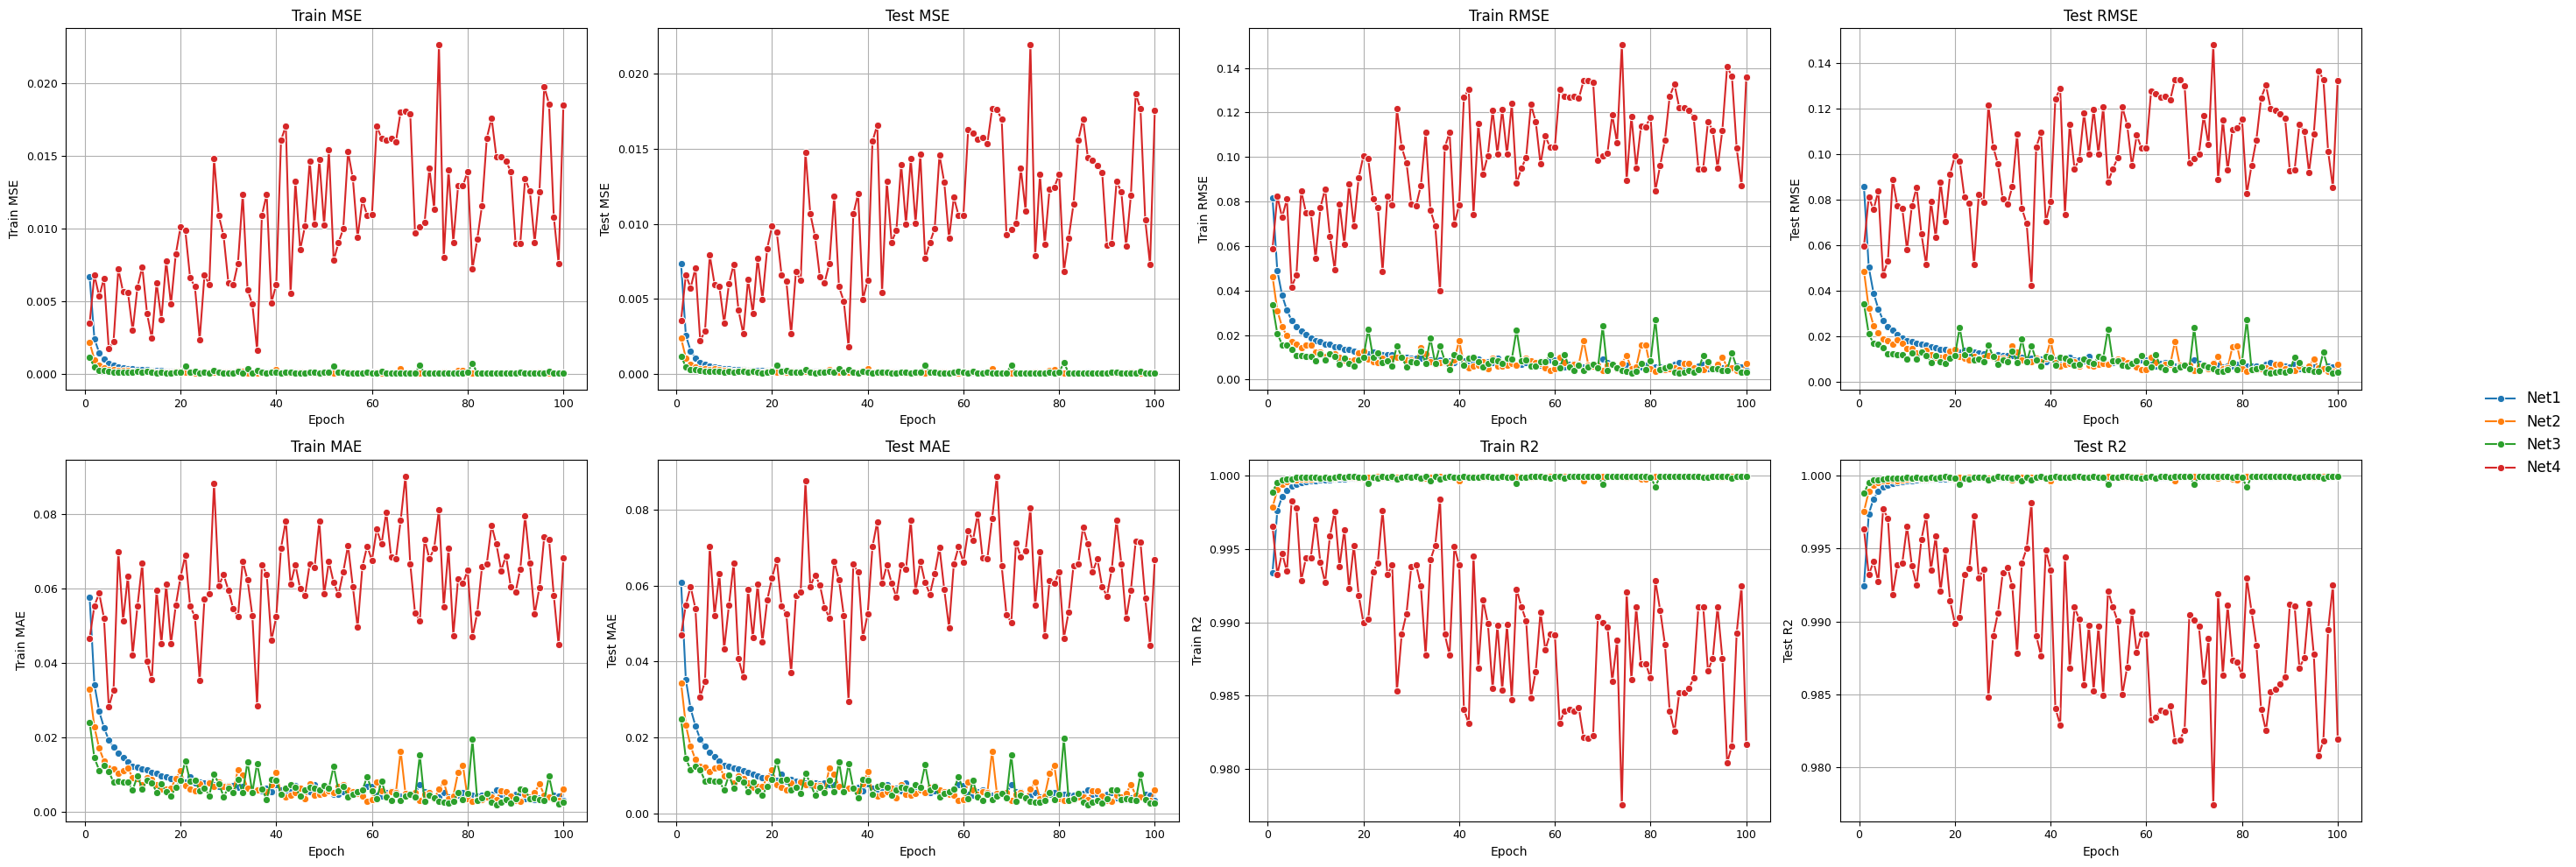

In [22]:
train_figures = {}

metrics_to_plot = ["Train MSE", "Test MSE", "Train RMSE", "Test RMSE", 
                   "Train MAE", "Test MAE", "Train R2", "Test R2"]

n_metrics = len(metrics_to_plot)
ncols = 4
nrows = (n_metrics + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows, ncols, figsize=(28, 10), sharey=False)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=nn_metrics_df, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

for j in range(n_metrics, len(axes)):
    fig.delaxes(axes[j])
    
if handles and labels:
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5),
               fontsize="large", frameon=False)

plt.tight_layout(rect=[0, 0, 0.97, 1])  
train_figures["Train_Metrics_Nets"] = fig
plt.show()
plt.close()

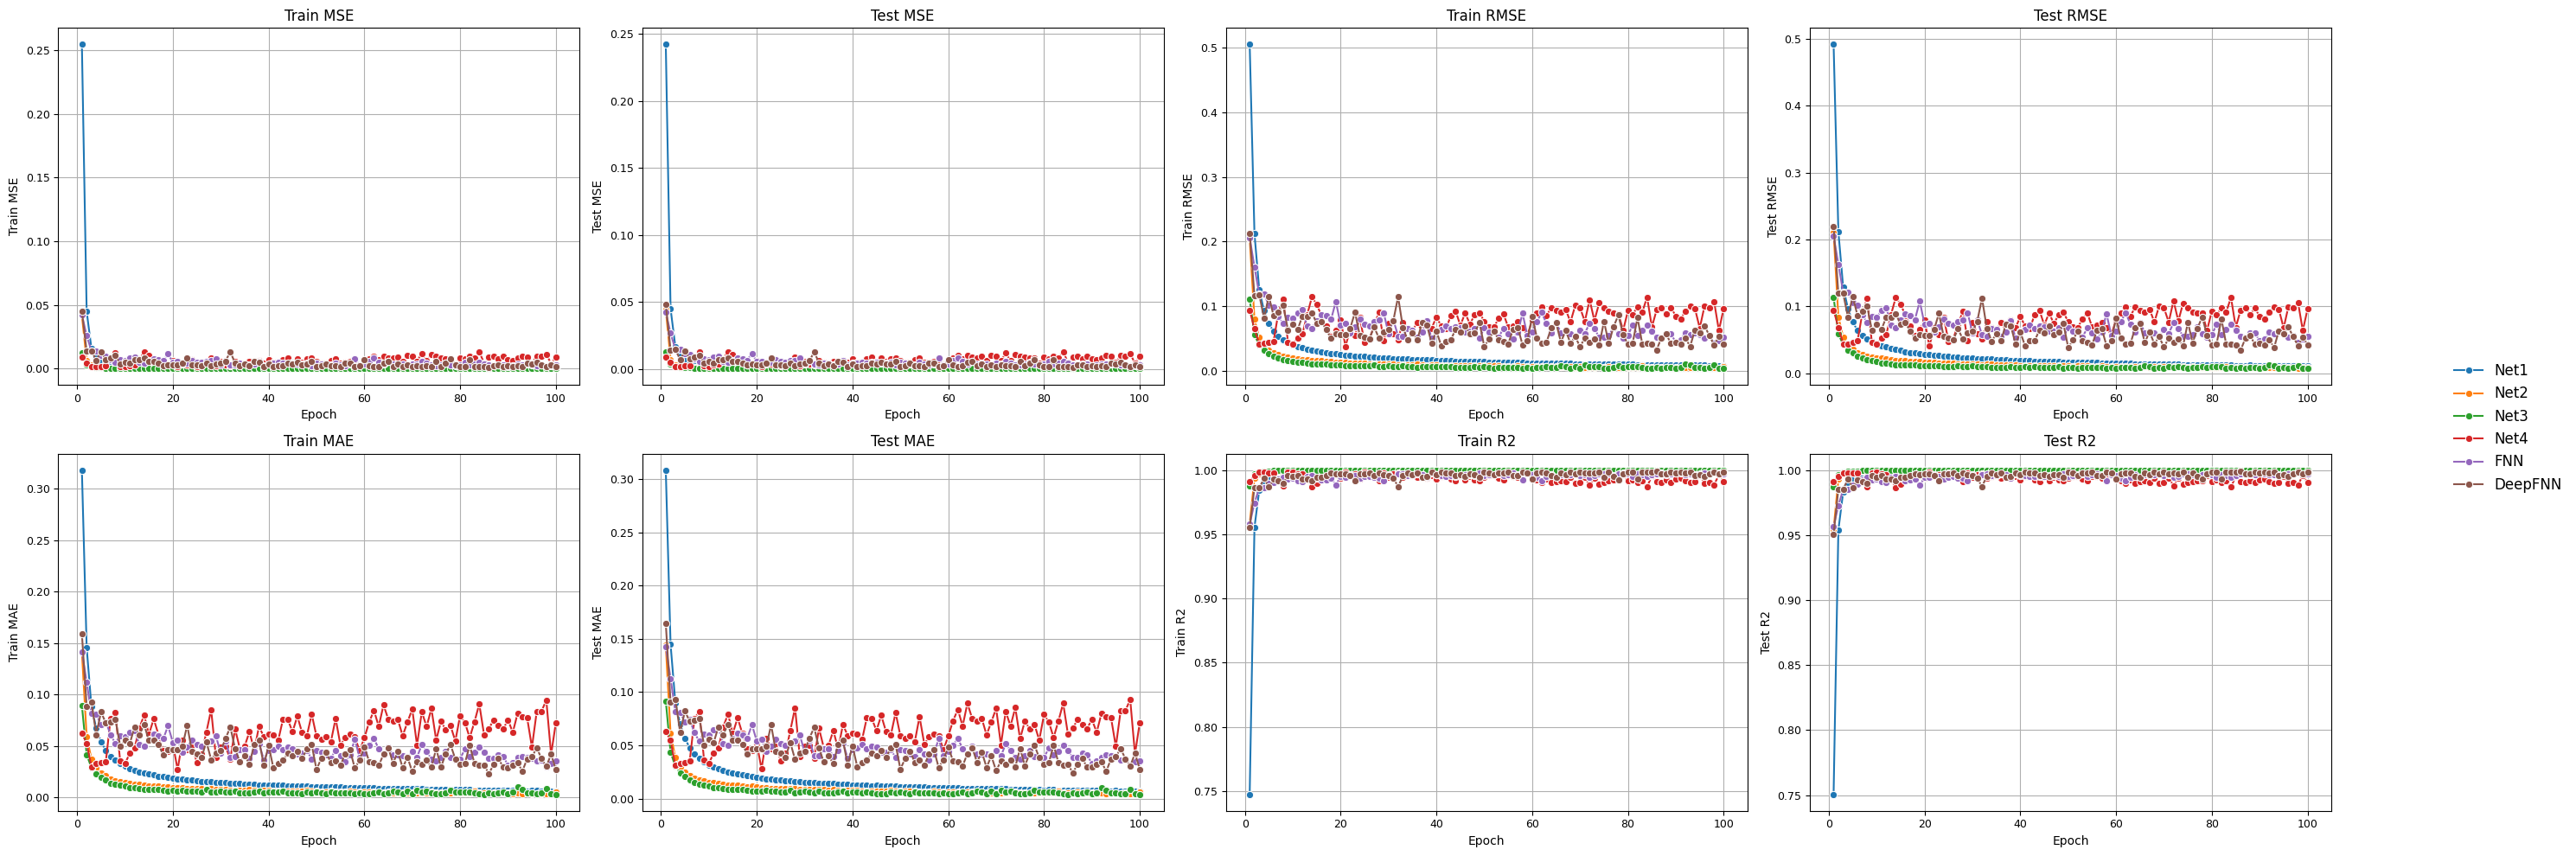

In [23]:
train_figures_tabular = {}

n_metrics = len(metrics_to_plot)
ncols = 4
nrows = (n_metrics + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows, ncols, figsize=(28, 10), sharey=False)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=nn_metrics_df_tabular, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

for j in range(n_metrics, len(axes)):
    fig.delaxes(axes[j])
    
if handles and labels:
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5),
               fontsize="large", frameon=False)

plt.tight_layout(rect=[0, 0, 0.97, 1])  
train_figures_tabular["Train_Metrics_Tabular"] = fig
plt.show()
plt.close()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values,         
    y.values,        
    test_size=0.2,
    shuffle=False
)

scaler_X = StandardScaler().fit(X_train)
X_train_scaled = scaler_X.transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)

y_mean, y_std    = y_train.mean(), y_train.std()
y_train_norm     = (y_train - y_mean) / y_std
y_test_norm      = (y_test  - y_mean) / y_std

def create_sequence_data(X_arr, y_arr, seq_len=5):
    Xs, ys = [], []
    for i in range(len(X_arr) - seq_len):
        Xs.append(X_arr[i : i + seq_len])
        ys.append(y_arr[i + seq_len])
    return np.stack(Xs), np.stack(ys)

seq_len = 5
X_train_seq, y_train_seq = create_sequence_data(X_train_scaled, y_train_norm, seq_len)
X_test_seq,  y_test_seq  = create_sequence_data(X_test_scaled,  y_test_norm,  seq_len)

X_train_seq_tensor = torch.tensor(X_train_seq, dtype=torch.float32)  
y_train_seq_tensor = torch.tensor(y_train_seq, dtype=torch.float32).view(-1, 1)
X_test_seq_tensor  = torch.tensor(X_test_seq,  dtype=torch.float32)
y_test_seq_tensor  = torch.tensor(y_test_seq,  dtype=torch.float32).view(-1, 1)

train_loader_seq = DataLoader(
    TensorDataset(X_train_seq_tensor, y_train_seq_tensor),
    batch_size=64, shuffle=True
)
test_loader_seq  = DataLoader(
    TensorDataset(X_test_seq_tensor,  y_test_seq_tensor),
    batch_size=64, shuffle=False
)

In [25]:
in_channels = X_train_seq_tensor.shape[2]  

ts_nets = {
    "TCN":     TCN(in_channels, num_channels=[64,64]),
    "CNN1D":   CNN1D(in_channels, num_filters=32, num_layers=2, kernel_size=3, dropout=0.2),
    "GRUNet":  GRUNet(in_channels),
    "RNNNet":  RNNNet(in_channels),
    "CNNLSTM": CNNLSTM(in_channels),
    "BiLSTMNet":  BiLSTMNet(in_channels),
    "DeepLSTMNet":DeepLSTMNet(in_channels),
    "CNNBiLSTM":  CNNBiLSTM(in_channels),
    "GRUCNN":     GRUCNN(in_channels),
    "TCNLSTM":    TCNLSTM(in_channels),
    "Seq2SeqLSTM":Seq2SeqLSTM(in_channels),
}

In [26]:
results_ts = []
for name, net in ts_nets.items():
    results_ts += train_ts_model(
        name,
        net,
        train_loader_seq,       
        X_train_seq_tensor,     
        y_train_seq_tensor,     
        X_test_seq_tensor,      
        y_test_seq_tensor,      
        epochs=100,
        lr=1e-3
    )

nn_metrics_ts_df = pd.DataFrame(results_ts)

Training TCN:   1%|▉                                                                                        | 1/100 [00:12<20:02, 12.15s/it]


Model: TCN | Epoch: 1/100
Train: MSE: 0.0241, RMSE: 0.1554, MAE: 0.0968, R2: 0.9759
Test:  MSE: 0.0315, RMSE: 0.1775, MAE: 0.1184, R2: 0.9783


Training TCN:  10%|████████▊                                                                               | 10/100 [02:32<21:47, 14.53s/it]


Model: TCN | Epoch: 10/100
Train: MSE: 0.0140, RMSE: 0.1183, MAE: 0.0690, R2: 0.9860
Test:  MSE: 0.0189, RMSE: 0.1375, MAE: 0.0897, R2: 0.9869


Training TCN:  20%|█████████████████▌                                                                      | 20/100 [04:14<13:47, 10.35s/it]


Model: TCN | Epoch: 20/100
Train: MSE: 0.0118, RMSE: 0.1084, MAE: 0.0591, R2: 0.9883
Test:  MSE: 0.0155, RMSE: 0.1246, MAE: 0.0796, R2: 0.9893


Training TCN:  30%|██████████████████████████▍                                                             | 30/100 [06:06<14:12, 12.17s/it]


Model: TCN | Epoch: 30/100
Train: MSE: 0.0104, RMSE: 0.1021, MAE: 0.0567, R2: 0.9896
Test:  MSE: 0.0142, RMSE: 0.1194, MAE: 0.0791, R2: 0.9902


Training TCN:  40%|███████████████████████████████████▏                                                    | 40/100 [08:51<17:30, 17.51s/it]


Model: TCN | Epoch: 40/100
Train: MSE: 0.0084, RMSE: 0.0916, MAE: 0.0450, R2: 0.9916
Test:  MSE: 0.0104, RMSE: 0.1018, MAE: 0.0579, R2: 0.9928


Training TCN:  50%|████████████████████████████████████████████                                            | 50/100 [11:51<14:45, 17.71s/it]


Model: TCN | Epoch: 50/100
Train: MSE: 0.0076, RMSE: 0.0870, MAE: 0.0421, R2: 0.9924
Test:  MSE: 0.0091, RMSE: 0.0952, MAE: 0.0546, R2: 0.9937


Training TCN:  60%|████████████████████████████████████████████████████▊                                   | 60/100 [14:54<12:36, 18.90s/it]


Model: TCN | Epoch: 60/100
Train: MSE: 0.0070, RMSE: 0.0838, MAE: 0.0455, R2: 0.9930
Test:  MSE: 0.0089, RMSE: 0.0943, MAE: 0.0596, R2: 0.9939


Training TCN:  70%|█████████████████████████████████████████████████████████████▌                          | 70/100 [17:48<07:28, 14.96s/it]


Model: TCN | Epoch: 70/100
Train: MSE: 0.0062, RMSE: 0.0788, MAE: 0.0399, R2: 0.9938
Test:  MSE: 0.0078, RMSE: 0.0883, MAE: 0.0521, R2: 0.9946


Training TCN:  80%|██████████████████████████████████████████████████████████████████████▍                 | 80/100 [20:14<05:06, 15.35s/it]


Model: TCN | Epoch: 80/100
Train: MSE: 0.0053, RMSE: 0.0726, MAE: 0.0396, R2: 0.9947
Test:  MSE: 0.0073, RMSE: 0.0852, MAE: 0.0546, R2: 0.9950


Training TCN:  90%|███████████████████████████████████████████████████████████████████████████████▏        | 90/100 [22:53<02:39, 15.98s/it]


Model: TCN | Epoch: 90/100
Train: MSE: 0.0050, RMSE: 0.0704, MAE: 0.0358, R2: 0.9950
Test:  MSE: 0.0068, RMSE: 0.0825, MAE: 0.0479, R2: 0.9953


Training TCN: 100%|███████████████████████████████████████████████████████████████████████████████████████| 100/100 [25:27<00:00, 15.28s/it]



Model: TCN | Epoch: 100/100
Train: MSE: 0.0040, RMSE: 0.0632, MAE: 0.0321, R2: 0.9960
Test:  MSE: 0.0058, RMSE: 0.0761, MAE: 0.0426, R2: 0.9960


Training CNN1D:   1%|▊                                                                                      | 1/100 [00:01<02:47,  1.70s/it]


Model: CNN1D | Epoch: 1/100
Train: MSE: 0.0961, RMSE: 0.3100, MAE: 0.1933, R2: 0.9039
Test:  MSE: 0.1324, RMSE: 0.3639, MAE: 0.2536, R2: 0.9086


Training CNN1D:  10%|████████▌                                                                             | 10/100 [00:16<02:31,  1.68s/it]


Model: CNN1D | Epoch: 10/100
Train: MSE: 0.0202, RMSE: 0.1422, MAE: 0.0725, R2: 0.9798
Test:  MSE: 0.0239, RMSE: 0.1546, MAE: 0.0868, R2: 0.9835


Training CNN1D:  20%|█████████████████▏                                                                    | 20/100 [00:33<02:15,  1.69s/it]


Model: CNN1D | Epoch: 20/100
Train: MSE: 0.0169, RMSE: 0.1300, MAE: 0.0735, R2: 0.9831
Test:  MSE: 0.0198, RMSE: 0.1407, MAE: 0.0856, R2: 0.9863


Training CNN1D:  30%|█████████████████████████▊                                                            | 30/100 [00:50<01:56,  1.67s/it]


Model: CNN1D | Epoch: 30/100
Train: MSE: 0.0165, RMSE: 0.1284, MAE: 0.0713, R2: 0.9835
Test:  MSE: 0.0195, RMSE: 0.1396, MAE: 0.0847, R2: 0.9865


Training CNN1D:  40%|██████████████████████████████████▍                                                   | 40/100 [01:07<01:40,  1.68s/it]


Model: CNN1D | Epoch: 40/100
Train: MSE: 0.0147, RMSE: 0.1213, MAE: 0.0691, R2: 0.9853
Test:  MSE: 0.0188, RMSE: 0.1370, MAE: 0.0845, R2: 0.9870


Training CNN1D:  50%|███████████████████████████████████████████                                           | 50/100 [01:24<01:23,  1.67s/it]


Model: CNN1D | Epoch: 50/100
Train: MSE: 0.0124, RMSE: 0.1111, MAE: 0.0564, R2: 0.9877
Test:  MSE: 0.0133, RMSE: 0.1153, MAE: 0.0639, R2: 0.9908


Training CNN1D:  60%|███████████████████████████████████████████████████▌                                  | 60/100 [01:40<01:06,  1.67s/it]


Model: CNN1D | Epoch: 60/100
Train: MSE: 0.0114, RMSE: 0.1070, MAE: 0.0531, R2: 0.9886
Test:  MSE: 0.0129, RMSE: 0.1137, MAE: 0.0649, R2: 0.9911


Training CNN1D:  70%|████████████████████████████████████████████████████████████▏                         | 70/100 [01:57<00:50,  1.68s/it]


Model: CNN1D | Epoch: 70/100
Train: MSE: 0.0113, RMSE: 0.1062, MAE: 0.0536, R2: 0.9887
Test:  MSE: 0.0136, RMSE: 0.1165, MAE: 0.0660, R2: 0.9906


Training CNN1D:  80%|████████████████████████████████████████████████████████████████████▊                 | 80/100 [02:14<00:33,  1.66s/it]


Model: CNN1D | Epoch: 80/100
Train: MSE: 0.0115, RMSE: 0.1070, MAE: 0.0542, R2: 0.9885
Test:  MSE: 0.0138, RMSE: 0.1173, MAE: 0.0692, R2: 0.9905


Training CNN1D:  90%|█████████████████████████████████████████████████████████████████████████████▍        | 90/100 [02:30<00:16,  1.65s/it]


Model: CNN1D | Epoch: 90/100
Train: MSE: 0.0096, RMSE: 0.0981, MAE: 0.0469, R2: 0.9904
Test:  MSE: 0.0107, RMSE: 0.1036, MAE: 0.0558, R2: 0.9926


Training CNN1D: 100%|█████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:47<00:00,  1.67s/it]



Model: CNN1D | Epoch: 100/100
Train: MSE: 0.0100, RMSE: 0.1001, MAE: 0.0538, R2: 0.9900
Test:  MSE: 0.0108, RMSE: 0.1041, MAE: 0.0599, R2: 0.9925


Training GRUNet:   1%|▊                                                                                     | 1/100 [00:01<01:52,  1.13s/it]


Model: GRUNet | Epoch: 1/100
Train: MSE: 0.0385, RMSE: 0.1961, MAE: 0.1058, R2: 0.9616
Test:  MSE: 0.0441, RMSE: 0.2099, MAE: 0.1211, R2: 0.9696


Training GRUNet:  10%|████████▌                                                                            | 10/100 [00:11<01:38,  1.10s/it]


Model: GRUNet | Epoch: 10/100
Train: MSE: 0.0155, RMSE: 0.1247, MAE: 0.0665, R2: 0.9845
Test:  MSE: 0.0192, RMSE: 0.1386, MAE: 0.0763, R2: 0.9867


Training GRUNet:  20%|█████████████████                                                                    | 20/100 [00:22<01:25,  1.07s/it]


Model: GRUNet | Epoch: 20/100
Train: MSE: 0.0111, RMSE: 0.1055, MAE: 0.0534, R2: 0.9889
Test:  MSE: 0.0129, RMSE: 0.1134, MAE: 0.0638, R2: 0.9911


Training GRUNet:  30%|█████████████████████████▌                                                           | 30/100 [00:32<01:15,  1.08s/it]


Model: GRUNet | Epoch: 30/100
Train: MSE: 0.0088, RMSE: 0.0938, MAE: 0.0437, R2: 0.9912
Test:  MSE: 0.0103, RMSE: 0.1017, MAE: 0.0523, R2: 0.9929


Training GRUNet:  40%|██████████████████████████████████                                                   | 40/100 [00:43<01:04,  1.08s/it]


Model: GRUNet | Epoch: 40/100
Train: MSE: 0.0069, RMSE: 0.0832, MAE: 0.0404, R2: 0.9931
Test:  MSE: 0.0084, RMSE: 0.0919, MAE: 0.0492, R2: 0.9942


Training GRUNet:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:54<00:53,  1.06s/it]


Model: GRUNet | Epoch: 50/100
Train: MSE: 0.0050, RMSE: 0.0705, MAE: 0.0405, R2: 0.9950
Test:  MSE: 0.0084, RMSE: 0.0917, MAE: 0.0509, R2: 0.9942


Training GRUNet:  60%|███████████████████████████████████████████████████                                  | 60/100 [01:05<00:44,  1.10s/it]


Model: GRUNet | Epoch: 60/100
Train: MSE: 0.0037, RMSE: 0.0608, MAE: 0.0333, R2: 0.9963
Test:  MSE: 0.0055, RMSE: 0.0745, MAE: 0.0413, R2: 0.9962


Training GRUNet:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [01:15<00:33,  1.11s/it]


Model: GRUNet | Epoch: 70/100
Train: MSE: 0.0020, RMSE: 0.0448, MAE: 0.0268, R2: 0.9980
Test:  MSE: 0.0039, RMSE: 0.0625, MAE: 0.0341, R2: 0.9973


Training GRUNet:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [01:26<00:20,  1.05s/it]


Model: GRUNet | Epoch: 80/100
Train: MSE: 0.0015, RMSE: 0.0382, MAE: 0.0248, R2: 0.9985
Test:  MSE: 0.0028, RMSE: 0.0527, MAE: 0.0312, R2: 0.9981


Training GRUNet:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [01:37<00:10,  1.06s/it]


Model: GRUNet | Epoch: 90/100
Train: MSE: 0.0012, RMSE: 0.0352, MAE: 0.0224, R2: 0.9988
Test:  MSE: 0.0024, RMSE: 0.0486, MAE: 0.0292, R2: 0.9984


Training GRUNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/it]



Model: GRUNet | Epoch: 100/100
Train: MSE: 0.0011, RMSE: 0.0336, MAE: 0.0226, R2: 0.9989
Test:  MSE: 0.0021, RMSE: 0.0460, MAE: 0.0291, R2: 0.9985


Training RNNNet:   1%|▊                                                                                     | 1/100 [00:00<00:54,  1.80it/s]


Model: RNNNet | Epoch: 1/100
Train: MSE: 0.0200, RMSE: 0.1414, MAE: 0.0776, R2: 0.9800
Test:  MSE: 0.0220, RMSE: 0.1484, MAE: 0.0864, R2: 0.9848


Training RNNNet:  10%|████████▌                                                                            | 10/100 [00:05<00:52,  1.71it/s]


Model: RNNNet | Epoch: 10/100
Train: MSE: 0.0137, RMSE: 0.1170, MAE: 0.0657, R2: 0.9863
Test:  MSE: 0.0142, RMSE: 0.1193, MAE: 0.0695, R2: 0.9902


Training RNNNet:  20%|█████████████████                                                                    | 20/100 [00:11<00:45,  1.74it/s]


Model: RNNNet | Epoch: 20/100
Train: MSE: 0.0119, RMSE: 0.1090, MAE: 0.0611, R2: 0.9881
Test:  MSE: 0.0132, RMSE: 0.1148, MAE: 0.0731, R2: 0.9909


Training RNNNet:  30%|█████████████████████████▌                                                           | 30/100 [00:17<00:37,  1.84it/s]


Model: RNNNet | Epoch: 30/100
Train: MSE: 0.0100, RMSE: 0.1002, MAE: 0.0555, R2: 0.9900
Test:  MSE: 0.0112, RMSE: 0.1058, MAE: 0.0661, R2: 0.9923


Training RNNNet:  40%|██████████████████████████████████                                                   | 40/100 [00:23<00:43,  1.39it/s]


Model: RNNNet | Epoch: 40/100
Train: MSE: 0.0100, RMSE: 0.0999, MAE: 0.0545, R2: 0.9900
Test:  MSE: 0.0117, RMSE: 0.1080, MAE: 0.0677, R2: 0.9920


Training RNNNet:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:29<00:29,  1.70it/s]


Model: RNNNet | Epoch: 50/100
Train: MSE: 0.0058, RMSE: 0.0758, MAE: 0.0399, R2: 0.9943
Test:  MSE: 0.0065, RMSE: 0.0806, MAE: 0.0484, R2: 0.9955


Training RNNNet:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:35<00:22,  1.76it/s]


Model: RNNNet | Epoch: 60/100
Train: MSE: 0.0043, RMSE: 0.0654, MAE: 0.0353, R2: 0.9957
Test:  MSE: 0.0053, RMSE: 0.0728, MAE: 0.0441, R2: 0.9963


Training RNNNet:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:40<00:14,  2.06it/s]


Model: RNNNet | Epoch: 70/100
Train: MSE: 0.0038, RMSE: 0.0613, MAE: 0.0293, R2: 0.9962
Test:  MSE: 0.0037, RMSE: 0.0611, MAE: 0.0370, R2: 0.9974


Training RNNNet:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:44<00:09,  2.10it/s]


Model: RNNNet | Epoch: 80/100
Train: MSE: 0.0023, RMSE: 0.0479, MAE: 0.0271, R2: 0.9977
Test:  MSE: 0.0032, RMSE: 0.0564, MAE: 0.0343, R2: 0.9978


Training RNNNet:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:49<00:04,  2.09it/s]


Model: RNNNet | Epoch: 90/100
Train: MSE: 0.0020, RMSE: 0.0451, MAE: 0.0265, R2: 0.9980
Test:  MSE: 0.0027, RMSE: 0.0522, MAE: 0.0333, R2: 0.9981


Training RNNNet: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:54<00:00,  1.83it/s]



Model: RNNNet | Epoch: 100/100
Train: MSE: 0.0015, RMSE: 0.0383, MAE: 0.0231, R2: 0.9985
Test:  MSE: 0.0021, RMSE: 0.0461, MAE: 0.0286, R2: 0.9985


Training CNNLSTM:   1%|▊                                                                                    | 1/100 [00:15<25:48, 15.65s/it]


Model: CNNLSTM | Epoch: 1/100
Train: MSE: 0.1159, RMSE: 0.3404, MAE: 0.2014, R2: 0.8842
Test:  MSE: 0.1217, RMSE: 0.3488, MAE: 0.2319, R2: 0.9160


Training CNNLSTM:  10%|████████▍                                                                           | 10/100 [02:15<19:17, 12.87s/it]


Model: CNNLSTM | Epoch: 10/100
Train: MSE: 0.0296, RMSE: 0.1719, MAE: 0.0907, R2: 0.9705
Test:  MSE: 0.0313, RMSE: 0.1769, MAE: 0.1070, R2: 0.9784


Training CNNLSTM:  20%|████████████████▊                                                                   | 20/100 [03:35<10:30,  7.88s/it]


Model: CNNLSTM | Epoch: 20/100
Train: MSE: 0.0193, RMSE: 0.1388, MAE: 0.0722, R2: 0.9807
Test:  MSE: 0.0230, RMSE: 0.1517, MAE: 0.0876, R2: 0.9841


Training CNNLSTM:  30%|█████████████████████████▏                                                          | 30/100 [04:50<08:46,  7.53s/it]


Model: CNNLSTM | Epoch: 30/100
Train: MSE: 0.0155, RMSE: 0.1244, MAE: 0.0667, R2: 0.9845
Test:  MSE: 0.0186, RMSE: 0.1365, MAE: 0.0827, R2: 0.9871


Training CNNLSTM:  40%|█████████████████████████████████▌                                                  | 40/100 [06:16<08:58,  8.97s/it]


Model: CNNLSTM | Epoch: 40/100
Train: MSE: 0.0317, RMSE: 0.1779, MAE: 0.1017, R2: 0.9684
Test:  MSE: 0.0438, RMSE: 0.2093, MAE: 0.1360, R2: 0.9698


Training CNNLSTM:  50%|██████████████████████████████████████████                                          | 50/100 [07:36<06:18,  7.57s/it]


Model: CNNLSTM | Epoch: 50/100
Train: MSE: 0.0115, RMSE: 0.1073, MAE: 0.0557, R2: 0.9885
Test:  MSE: 0.0123, RMSE: 0.1108, MAE: 0.0622, R2: 0.9915


Training CNNLSTM:  60%|██████████████████████████████████████████████████▍                                 | 60/100 [08:57<05:18,  7.95s/it]


Model: CNNLSTM | Epoch: 60/100
Train: MSE: 0.0100, RMSE: 0.0998, MAE: 0.0506, R2: 0.9900
Test:  MSE: 0.0120, RMSE: 0.1097, MAE: 0.0578, R2: 0.9917


Training CNNLSTM:  70%|██████████████████████████████████████████████████████████▊                         | 70/100 [10:23<03:52,  7.74s/it]


Model: CNNLSTM | Epoch: 70/100
Train: MSE: 0.0088, RMSE: 0.0937, MAE: 0.0477, R2: 0.9912
Test:  MSE: 0.0084, RMSE: 0.0915, MAE: 0.0539, R2: 0.9942


Training CNNLSTM:  80%|███████████████████████████████████████████████████████████████████▏                | 80/100 [11:48<02:48,  8.43s/it]


Model: CNNLSTM | Epoch: 80/100
Train: MSE: 0.0091, RMSE: 0.0955, MAE: 0.0503, R2: 0.9909
Test:  MSE: 0.0095, RMSE: 0.0972, MAE: 0.0591, R2: 0.9935


Training CNNLSTM:  90%|███████████████████████████████████████████████████████████████████████████▌        | 90/100 [14:11<02:17, 13.77s/it]


Model: CNNLSTM | Epoch: 90/100
Train: MSE: 0.0068, RMSE: 0.0822, MAE: 0.0419, R2: 0.9932
Test:  MSE: 0.0062, RMSE: 0.0788, MAE: 0.0465, R2: 0.9957


Training CNNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [16:30<00:00,  9.91s/it]



Model: CNNLSTM | Epoch: 100/100
Train: MSE: 0.0077, RMSE: 0.0878, MAE: 0.0462, R2: 0.9923
Test:  MSE: 0.0073, RMSE: 0.0854, MAE: 0.0543, R2: 0.9950


Training BiLSTMNet:   1%|▊                                                                                  | 1/100 [00:01<02:52,  1.74s/it]


Model: BiLSTMNet | Epoch: 1/100
Train: MSE: 0.0376, RMSE: 0.1940, MAE: 0.1000, R2: 0.9624
Test:  MSE: 0.0401, RMSE: 0.2002, MAE: 0.1166, R2: 0.9723


Training BiLSTMNet:  10%|████████▏                                                                         | 10/100 [00:18<03:08,  2.09s/it]


Model: BiLSTMNet | Epoch: 10/100
Train: MSE: 0.0187, RMSE: 0.1369, MAE: 0.0721, R2: 0.9813
Test:  MSE: 0.0229, RMSE: 0.1512, MAE: 0.0881, R2: 0.9842


Training BiLSTMNet:  20%|████████████████▍                                                                 | 20/100 [00:38<02:44,  2.05s/it]


Model: BiLSTMNet | Epoch: 20/100
Train: MSE: 0.0154, RMSE: 0.1241, MAE: 0.0628, R2: 0.9846
Test:  MSE: 0.0194, RMSE: 0.1394, MAE: 0.0759, R2: 0.9866


Training BiLSTMNet:  30%|████████████████████████▌                                                         | 30/100 [01:04<02:35,  2.22s/it]


Model: BiLSTMNet | Epoch: 30/100
Train: MSE: 0.0124, RMSE: 0.1115, MAE: 0.0558, R2: 0.9876
Test:  MSE: 0.0160, RMSE: 0.1264, MAE: 0.0648, R2: 0.9890


Training BiLSTMNet:  40%|████████████████████████████████▊                                                 | 40/100 [01:22<01:49,  1.83s/it]


Model: BiLSTMNet | Epoch: 40/100
Train: MSE: 0.0094, RMSE: 0.0967, MAE: 0.0485, R2: 0.9906
Test:  MSE: 0.0103, RMSE: 0.1017, MAE: 0.0559, R2: 0.9929


Training BiLSTMNet:  50%|█████████████████████████████████████████                                         | 50/100 [01:43<01:39,  2.00s/it]


Model: BiLSTMNet | Epoch: 50/100
Train: MSE: 0.0080, RMSE: 0.0893, MAE: 0.0488, R2: 0.9920
Test:  MSE: 0.0097, RMSE: 0.0985, MAE: 0.0584, R2: 0.9933


Training BiLSTMNet:  60%|█████████████████████████████████████████████████▏                                | 60/100 [02:04<01:27,  2.18s/it]


Model: BiLSTMNet | Epoch: 60/100
Train: MSE: 0.0061, RMSE: 0.0780, MAE: 0.0408, R2: 0.9939
Test:  MSE: 0.0096, RMSE: 0.0982, MAE: 0.0514, R2: 0.9933


Training BiLSTMNet:  70%|█████████████████████████████████████████████████████████▍                        | 70/100 [02:25<01:09,  2.32s/it]


Model: BiLSTMNet | Epoch: 70/100
Train: MSE: 0.0051, RMSE: 0.0714, MAE: 0.0394, R2: 0.9949
Test:  MSE: 0.0075, RMSE: 0.0868, MAE: 0.0474, R2: 0.9948


Training BiLSTMNet:  80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [02:43<00:36,  1.81s/it]


Model: BiLSTMNet | Epoch: 80/100
Train: MSE: 0.0038, RMSE: 0.0613, MAE: 0.0351, R2: 0.9962
Test:  MSE: 0.0058, RMSE: 0.0761, MAE: 0.0440, R2: 0.9960


Training BiLSTMNet:  90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [03:06<00:24,  2.41s/it]


Model: BiLSTMNet | Epoch: 90/100
Train: MSE: 0.0038, RMSE: 0.0619, MAE: 0.0360, R2: 0.9962
Test:  MSE: 0.0081, RMSE: 0.0902, MAE: 0.0473, R2: 0.9944


Training BiLSTMNet: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [03:25<00:00,  2.06s/it]



Model: BiLSTMNet | Epoch: 100/100
Train: MSE: 0.0027, RMSE: 0.0522, MAE: 0.0300, R2: 0.9973
Test:  MSE: 0.0058, RMSE: 0.0762, MAE: 0.0380, R2: 0.9960


Training DeepLSTMNet:   1%|▊                                                                                | 1/100 [00:03<05:44,  3.48s/it]


Model: DeepLSTMNet | Epoch: 1/100
Train: MSE: 0.0406, RMSE: 0.2015, MAE: 0.1039, R2: 0.9594
Test:  MSE: 0.0482, RMSE: 0.2195, MAE: 0.1278, R2: 0.9667


Training DeepLSTMNet:  10%|████████                                                                        | 10/100 [00:33<04:43,  3.15s/it]


Model: DeepLSTMNet | Epoch: 10/100
Train: MSE: 0.0208, RMSE: 0.1442, MAE: 0.0723, R2: 0.9792
Test:  MSE: 0.0233, RMSE: 0.1528, MAE: 0.0854, R2: 0.9839


Training DeepLSTMNet:  20%|████████████████                                                                | 20/100 [01:02<03:56,  2.96s/it]


Model: DeepLSTMNet | Epoch: 20/100
Train: MSE: 0.0202, RMSE: 0.1421, MAE: 0.0716, R2: 0.9798
Test:  MSE: 0.0296, RMSE: 0.1721, MAE: 0.0854, R2: 0.9796


Training DeepLSTMNet:  30%|████████████████████████                                                        | 30/100 [01:33<03:35,  3.08s/it]


Model: DeepLSTMNet | Epoch: 30/100
Train: MSE: 0.0121, RMSE: 0.1101, MAE: 0.0569, R2: 0.9879
Test:  MSE: 0.0161, RMSE: 0.1270, MAE: 0.0695, R2: 0.9889


Training DeepLSTMNet:  40%|████████████████████████████████                                                | 40/100 [02:08<03:33,  3.55s/it]


Model: DeepLSTMNet | Epoch: 40/100
Train: MSE: 0.0108, RMSE: 0.1040, MAE: 0.0532, R2: 0.9892
Test:  MSE: 0.0135, RMSE: 0.1160, MAE: 0.0635, R2: 0.9907


Training DeepLSTMNet:  50%|████████████████████████████████████████                                        | 50/100 [02:35<02:13,  2.67s/it]


Model: DeepLSTMNet | Epoch: 50/100
Train: MSE: 0.0080, RMSE: 0.0892, MAE: 0.0437, R2: 0.9920
Test:  MSE: 0.0138, RMSE: 0.1174, MAE: 0.0559, R2: 0.9905


Training DeepLSTMNet:  60%|████████████████████████████████████████████████                                | 60/100 [03:04<02:01,  3.03s/it]


Model: DeepLSTMNet | Epoch: 60/100
Train: MSE: 0.0067, RMSE: 0.0819, MAE: 0.0400, R2: 0.9933
Test:  MSE: 0.0094, RMSE: 0.0968, MAE: 0.0502, R2: 0.9935


Training DeepLSTMNet:  70%|████████████████████████████████████████████████████████                        | 70/100 [03:36<01:44,  3.47s/it]


Model: DeepLSTMNet | Epoch: 70/100
Train: MSE: 0.0052, RMSE: 0.0720, MAE: 0.0375, R2: 0.9948
Test:  MSE: 0.0087, RMSE: 0.0932, MAE: 0.0515, R2: 0.9940


Training DeepLSTMNet:  80%|████████████████████████████████████████████████████████████████                | 80/100 [04:08<01:07,  3.36s/it]


Model: DeepLSTMNet | Epoch: 80/100
Train: MSE: 0.0047, RMSE: 0.0683, MAE: 0.0363, R2: 0.9953
Test:  MSE: 0.0070, RMSE: 0.0839, MAE: 0.0448, R2: 0.9951


Training DeepLSTMNet:  90%|████████████████████████████████████████████████████████████████████████        | 90/100 [04:39<00:32,  3.24s/it]


Model: DeepLSTMNet | Epoch: 90/100
Train: MSE: 0.0042, RMSE: 0.0646, MAE: 0.0292, R2: 0.9958
Test:  MSE: 0.0064, RMSE: 0.0802, MAE: 0.0370, R2: 0.9956


Training DeepLSTMNet: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [05:10<00:00,  3.11s/it]



Model: DeepLSTMNet | Epoch: 100/100
Train: MSE: 0.0044, RMSE: 0.0664, MAE: 0.0357, R2: 0.9956
Test:  MSE: 0.0069, RMSE: 0.0832, MAE: 0.0457, R2: 0.9952


Training CNNBiLSTM:   1%|▊                                                                                  | 1/100 [00:02<04:05,  2.48s/it]


Model: CNNBiLSTM | Epoch: 1/100
Train: MSE: 0.0341, RMSE: 0.1847, MAE: 0.0938, R2: 0.9659
Test:  MSE: 0.0307, RMSE: 0.1752, MAE: 0.1022, R2: 0.9788


Training CNNBiLSTM:  10%|████████▏                                                                         | 10/100 [00:19<02:48,  1.88s/it]


Model: CNNBiLSTM | Epoch: 10/100
Train: MSE: 0.0182, RMSE: 0.1351, MAE: 0.0686, R2: 0.9818
Test:  MSE: 0.0202, RMSE: 0.1423, MAE: 0.0808, R2: 0.9860


Training CNNBiLSTM:  20%|████████████████▍                                                                 | 20/100 [00:42<03:03,  2.30s/it]


Model: CNNBiLSTM | Epoch: 20/100
Train: MSE: 0.0137, RMSE: 0.1172, MAE: 0.0591, R2: 0.9863
Test:  MSE: 0.0152, RMSE: 0.1232, MAE: 0.0681, R2: 0.9895


Training CNNBiLSTM:  30%|████████████████████████▌                                                         | 30/100 [01:03<02:21,  2.02s/it]


Model: CNNBiLSTM | Epoch: 30/100
Train: MSE: 0.0122, RMSE: 0.1106, MAE: 0.0578, R2: 0.9878
Test:  MSE: 0.0131, RMSE: 0.1142, MAE: 0.0664, R2: 0.9910


Training CNNBiLSTM:  40%|████████████████████████████████▊                                                 | 40/100 [01:25<02:10,  2.18s/it]


Model: CNNBiLSTM | Epoch: 40/100
Train: MSE: 0.0101, RMSE: 0.1003, MAE: 0.0499, R2: 0.9899
Test:  MSE: 0.0107, RMSE: 0.1036, MAE: 0.0561, R2: 0.9926


Training CNNBiLSTM:  50%|█████████████████████████████████████████                                         | 50/100 [01:40<01:00,  1.21s/it]


Model: CNNBiLSTM | Epoch: 50/100
Train: MSE: 0.0089, RMSE: 0.0945, MAE: 0.0478, R2: 0.9911
Test:  MSE: 0.0094, RMSE: 0.0971, MAE: 0.0541, R2: 0.9935


Training CNNBiLSTM:  60%|█████████████████████████████████████████████████▏                                | 60/100 [01:50<00:40,  1.02s/it]


Model: CNNBiLSTM | Epoch: 60/100
Train: MSE: 0.0078, RMSE: 0.0884, MAE: 0.0441, R2: 0.9922
Test:  MSE: 0.0082, RMSE: 0.0906, MAE: 0.0520, R2: 0.9943


Training CNNBiLSTM:  70%|█████████████████████████████████████████████████████████▍                        | 70/100 [02:01<00:31,  1.06s/it]


Model: CNNBiLSTM | Epoch: 70/100
Train: MSE: 0.0071, RMSE: 0.0842, MAE: 0.0411, R2: 0.9929
Test:  MSE: 0.0071, RMSE: 0.0840, MAE: 0.0459, R2: 0.9951


Training CNNBiLSTM:  80%|█████████████████████████████████████████████████████████████████▌                | 80/100 [02:12<00:21,  1.09s/it]


Model: CNNBiLSTM | Epoch: 80/100
Train: MSE: 0.0064, RMSE: 0.0798, MAE: 0.0405, R2: 0.9936
Test:  MSE: 0.0065, RMSE: 0.0806, MAE: 0.0455, R2: 0.9955


Training CNNBiLSTM:  90%|█████████████████████████████████████████████████████████████████████████▊        | 90/100 [02:22<00:10,  1.10s/it]


Model: CNNBiLSTM | Epoch: 90/100
Train: MSE: 0.0059, RMSE: 0.0765, MAE: 0.0381, R2: 0.9941
Test:  MSE: 0.0061, RMSE: 0.0783, MAE: 0.0432, R2: 0.9958


Training CNNBiLSTM: 100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]



Model: CNNBiLSTM | Epoch: 100/100
Train: MSE: 0.0057, RMSE: 0.0753, MAE: 0.0371, R2: 0.9943
Test:  MSE: 0.0061, RMSE: 0.0784, MAE: 0.0429, R2: 0.9958


Training GRUCNN:   1%|▊                                                                                     | 1/100 [00:00<00:56,  1.74it/s]


Model: GRUCNN | Epoch: 1/100
Train: MSE: 0.0501, RMSE: 0.2239, MAE: 0.1113, R2: 0.9499
Test:  MSE: 0.0485, RMSE: 0.2202, MAE: 0.1248, R2: 0.9665


Training GRUCNN:  10%|████████▌                                                                            | 10/100 [00:05<00:54,  1.64it/s]


Model: GRUCNN | Epoch: 10/100
Train: MSE: 0.0261, RMSE: 0.1614, MAE: 0.0907, R2: 0.9740
Test:  MSE: 0.0319, RMSE: 0.1786, MAE: 0.1036, R2: 0.9780


Training GRUCNN:  20%|█████████████████                                                                    | 20/100 [00:11<00:44,  1.81it/s]


Model: GRUCNN | Epoch: 20/100
Train: MSE: 0.0170, RMSE: 0.1303, MAE: 0.0630, R2: 0.9830
Test:  MSE: 0.0196, RMSE: 0.1398, MAE: 0.0716, R2: 0.9865


Training GRUCNN:  30%|█████████████████████████▌                                                           | 30/100 [00:17<00:38,  1.82it/s]


Model: GRUCNN | Epoch: 30/100
Train: MSE: 0.0133, RMSE: 0.1154, MAE: 0.0593, R2: 0.9867
Test:  MSE: 0.0163, RMSE: 0.1275, MAE: 0.0673, R2: 0.9888


Training GRUCNN:  40%|██████████████████████████████████                                                   | 40/100 [00:22<00:32,  1.84it/s]


Model: GRUCNN | Epoch: 40/100
Train: MSE: 0.0111, RMSE: 0.1052, MAE: 0.0510, R2: 0.9889
Test:  MSE: 0.0155, RMSE: 0.1243, MAE: 0.0655, R2: 0.9893


Training GRUCNN:  50%|██████████████████████████████████████████▌                                          | 50/100 [00:28<00:27,  1.81it/s]


Model: GRUCNN | Epoch: 50/100
Train: MSE: 0.0139, RMSE: 0.1180, MAE: 0.0652, R2: 0.9861
Test:  MSE: 0.0189, RMSE: 0.1376, MAE: 0.0902, R2: 0.9869


Training GRUCNN:  60%|███████████████████████████████████████████████████                                  | 60/100 [00:33<00:22,  1.82it/s]


Model: GRUCNN | Epoch: 60/100
Train: MSE: 0.0092, RMSE: 0.0961, MAE: 0.0527, R2: 0.9908
Test:  MSE: 0.0126, RMSE: 0.1123, MAE: 0.0684, R2: 0.9913


Training GRUCNN:  70%|███████████████████████████████████████████████████████████▍                         | 70/100 [00:39<00:16,  1.81it/s]


Model: GRUCNN | Epoch: 70/100
Train: MSE: 0.0083, RMSE: 0.0910, MAE: 0.0491, R2: 0.9917
Test:  MSE: 0.0104, RMSE: 0.1020, MAE: 0.0639, R2: 0.9928


Training GRUCNN:  80%|████████████████████████████████████████████████████████████████████                 | 80/100 [00:44<00:11,  1.81it/s]


Model: GRUCNN | Epoch: 80/100
Train: MSE: 0.0086, RMSE: 0.0927, MAE: 0.0524, R2: 0.9914
Test:  MSE: 0.0133, RMSE: 0.1154, MAE: 0.0688, R2: 0.9908


Training GRUCNN:  90%|████████████████████████████████████████████████████████████████████████████▌        | 90/100 [00:50<00:05,  1.83it/s]


Model: GRUCNN | Epoch: 90/100
Train: MSE: 0.0051, RMSE: 0.0716, MAE: 0.0401, R2: 0.9949
Test:  MSE: 0.0072, RMSE: 0.0847, MAE: 0.0503, R2: 0.9950


Training GRUCNN: 100%|████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:55<00:00,  1.80it/s]



Model: GRUCNN | Epoch: 100/100
Train: MSE: 0.0085, RMSE: 0.0924, MAE: 0.0480, R2: 0.9915
Test:  MSE: 0.0139, RMSE: 0.1181, MAE: 0.0661, R2: 0.9904


Training TCNLSTM:   1%|▊                                                                                    | 1/100 [00:05<09:42,  5.88s/it]


Model: TCNLSTM | Epoch: 1/100
Train: MSE: 0.0223, RMSE: 0.1492, MAE: 0.0825, R2: 0.9777
Test:  MSE: 0.0251, RMSE: 0.1585, MAE: 0.1007, R2: 0.9827


Training TCNLSTM:  10%|████████▍                                                                           | 10/100 [00:58<08:49,  5.88s/it]


Model: TCNLSTM | Epoch: 10/100
Train: MSE: 0.0124, RMSE: 0.1113, MAE: 0.0551, R2: 0.9876
Test:  MSE: 0.0130, RMSE: 0.1141, MAE: 0.0627, R2: 0.9910


Training TCNLSTM:  20%|████████████████▊                                                                   | 20/100 [01:57<07:51,  5.90s/it]


Model: TCNLSTM | Epoch: 20/100
Train: MSE: 0.0102, RMSE: 0.1011, MAE: 0.0513, R2: 0.9898
Test:  MSE: 0.0108, RMSE: 0.1038, MAE: 0.0623, R2: 0.9926


Training TCNLSTM:  30%|█████████████████████████▏                                                          | 30/100 [02:57<06:58,  5.98s/it]


Model: TCNLSTM | Epoch: 30/100
Train: MSE: 0.0076, RMSE: 0.0872, MAE: 0.0418, R2: 0.9924
Test:  MSE: 0.0078, RMSE: 0.0883, MAE: 0.0497, R2: 0.9946


Training TCNLSTM:  40%|█████████████████████████████████▌                                                  | 40/100 [03:57<05:59,  6.00s/it]


Model: TCNLSTM | Epoch: 40/100
Train: MSE: 0.0061, RMSE: 0.0781, MAE: 0.0386, R2: 0.9939
Test:  MSE: 0.0060, RMSE: 0.0773, MAE: 0.0436, R2: 0.9959


Training TCNLSTM:  50%|██████████████████████████████████████████                                          | 50/100 [04:57<05:03,  6.07s/it]


Model: TCNLSTM | Epoch: 50/100
Train: MSE: 0.0049, RMSE: 0.0700, MAE: 0.0344, R2: 0.9951
Test:  MSE: 0.0048, RMSE: 0.0690, MAE: 0.0422, R2: 0.9967


Training TCNLSTM:  60%|██████████████████████████████████████████████████▍                                 | 60/100 [05:58<04:02,  6.05s/it]


Model: TCNLSTM | Epoch: 60/100
Train: MSE: 0.0039, RMSE: 0.0625, MAE: 0.0332, R2: 0.9961
Test:  MSE: 0.0042, RMSE: 0.0647, MAE: 0.0431, R2: 0.9971


Training TCNLSTM:  70%|██████████████████████████████████████████████████████████▊                         | 70/100 [06:59<03:02,  6.08s/it]


Model: TCNLSTM | Epoch: 70/100
Train: MSE: 0.0033, RMSE: 0.0571, MAE: 0.0287, R2: 0.9967
Test:  MSE: 0.0029, RMSE: 0.0537, MAE: 0.0349, R2: 0.9980


Training TCNLSTM:  80%|███████████████████████████████████████████████████████████████████▏                | 80/100 [08:08<02:39,  7.98s/it]


Model: TCNLSTM | Epoch: 80/100
Train: MSE: 0.0028, RMSE: 0.0530, MAE: 0.0239, R2: 0.9972
Test:  MSE: 0.0021, RMSE: 0.0463, MAE: 0.0283, R2: 0.9985


Training TCNLSTM:  90%|███████████████████████████████████████████████████████████████████████████▌        | 90/100 [09:42<01:33,  9.38s/it]


Model: TCNLSTM | Epoch: 90/100
Train: MSE: 0.0020, RMSE: 0.0452, MAE: 0.0236, R2: 0.9980
Test:  MSE: 0.0023, RMSE: 0.0482, MAE: 0.0293, R2: 0.9984


Training TCNLSTM: 100%|███████████████████████████████████████████████████████████████████████████████████| 100/100 [11:16<00:00,  6.76s/it]



Model: TCNLSTM | Epoch: 100/100
Train: MSE: 0.0024, RMSE: 0.0486, MAE: 0.0221, R2: 0.9976
Test:  MSE: 0.0017, RMSE: 0.0410, MAE: 0.0262, R2: 0.9988


Training Seq2SeqLSTM:   1%|▊                                                                                | 1/100 [00:01<01:42,  1.03s/it]


Model: Seq2SeqLSTM | Epoch: 1/100
Train: MSE: 0.0457, RMSE: 0.2138, MAE: 0.1086, R2: 0.9543
Test:  MSE: 0.0516, RMSE: 0.2272, MAE: 0.1315, R2: 0.9644


Training Seq2SeqLSTM:  10%|████████                                                                        | 10/100 [00:10<01:28,  1.02it/s]


Model: Seq2SeqLSTM | Epoch: 10/100
Train: MSE: 0.0166, RMSE: 0.1290, MAE: 0.0637, R2: 0.9834
Test:  MSE: 0.0240, RMSE: 0.1550, MAE: 0.0775, R2: 0.9834


Training Seq2SeqLSTM:  20%|████████████████                                                                | 20/100 [00:19<01:18,  1.02it/s]


Model: Seq2SeqLSTM | Epoch: 20/100
Train: MSE: 0.0116, RMSE: 0.1077, MAE: 0.0549, R2: 0.9884
Test:  MSE: 0.0160, RMSE: 0.1267, MAE: 0.0623, R2: 0.9889


Training Seq2SeqLSTM:  30%|████████████████████████                                                        | 30/100 [00:29<01:09,  1.01it/s]


Model: Seq2SeqLSTM | Epoch: 30/100
Train: MSE: 0.0101, RMSE: 0.1007, MAE: 0.0504, R2: 0.9899
Test:  MSE: 0.0156, RMSE: 0.1250, MAE: 0.0612, R2: 0.9892


Training Seq2SeqLSTM:  40%|████████████████████████████████                                                | 40/100 [00:39<00:59,  1.01it/s]


Model: Seq2SeqLSTM | Epoch: 40/100
Train: MSE: 0.0091, RMSE: 0.0952, MAE: 0.0472, R2: 0.9909
Test:  MSE: 0.0162, RMSE: 0.1274, MAE: 0.0570, R2: 0.9888


Training Seq2SeqLSTM:  50%|████████████████████████████████████████                                        | 50/100 [00:49<00:49,  1.00it/s]


Model: Seq2SeqLSTM | Epoch: 50/100
Train: MSE: 0.0050, RMSE: 0.0707, MAE: 0.0396, R2: 0.9950
Test:  MSE: 0.0133, RMSE: 0.1152, MAE: 0.0492, R2: 0.9908


Training Seq2SeqLSTM:  60%|████████████████████████████████████████████████                                | 60/100 [00:59<00:38,  1.04it/s]


Model: Seq2SeqLSTM | Epoch: 60/100
Train: MSE: 0.0039, RMSE: 0.0621, MAE: 0.0349, R2: 0.9961
Test:  MSE: 0.0112, RMSE: 0.1058, MAE: 0.0447, R2: 0.9923


Training Seq2SeqLSTM:  70%|████████████████████████████████████████████████████████                        | 70/100 [01:09<00:28,  1.04it/s]


Model: Seq2SeqLSTM | Epoch: 70/100
Train: MSE: 0.0032, RMSE: 0.0569, MAE: 0.0321, R2: 0.9968
Test:  MSE: 0.0109, RMSE: 0.1042, MAE: 0.0401, R2: 0.9925


Training Seq2SeqLSTM:  80%|████████████████████████████████████████████████████████████████                | 80/100 [01:19<00:19,  1.00it/s]


Model: Seq2SeqLSTM | Epoch: 80/100
Train: MSE: 0.0043, RMSE: 0.0656, MAE: 0.0308, R2: 0.9957
Test:  MSE: 0.0096, RMSE: 0.0978, MAE: 0.0399, R2: 0.9934


Training Seq2SeqLSTM:  90%|████████████████████████████████████████████████████████████████████████        | 90/100 [01:29<00:09,  1.01it/s]


Model: Seq2SeqLSTM | Epoch: 90/100
Train: MSE: 0.0019, RMSE: 0.0436, MAE: 0.0261, R2: 0.9981
Test:  MSE: 0.0063, RMSE: 0.0792, MAE: 0.0339, R2: 0.9957


Training Seq2SeqLSTM: 100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


Model: Seq2SeqLSTM | Epoch: 100/100
Train: MSE: 0.0017, RMSE: 0.0407, MAE: 0.0249, R2: 0.9983
Test:  MSE: 0.0051, RMSE: 0.0716, MAE: 0.0313, R2: 0.9965


In [27]:
best_idx = nn_metrics_ts_df.groupby("Model")["Test R2"].idxmax()
best_results_ts = nn_metrics_ts_df.loc[best_idx].reset_index(drop=True)
best_results_ts = best_results_ts[cols]
best_results_ts

Model  Epoch  Train MSE  Test MSE  Train RMSE  Test RMSE  Train MAE  \
0     BiLSTMNet     88   0.003259  0.004880    0.057085   0.069858   0.033069   
1         CNN1D     95   0.009322  0.010217    0.096553   0.101079   0.045895   
2     CNNBiLSTM     93   0.005542  0.005629    0.074446   0.075029   0.037171   
3       CNNLSTM     95   0.006471  0.006043    0.080444   0.077738   0.041715   
4   DeepLSTMNet     98   0.003084  0.004564    0.055538   0.067560   0.027623   
5        GRUCNN     98   0.004039  0.005806    0.063554   0.076199   0.035130   
6        GRUNet     97   0.001035  0.001859    0.032172   0.043122   0.020942   
7        RNNNet    100   0.001468  0.002128    0.038315   0.046132   0.023060   
8   Seq2SeqLSTM     95   0.001734  0.005080    0.041643   0.071272   0.025648   
9           TCN    100   0.003996  0.005799    0.063212   0.076148   0.032054   
10      TCNLSTM     99   0.001558  0.001449    0.039466   0.038067   0.019848   

    Test MAE  Train R2   Test R2  
0   0.041223  0.996743  0.996631  
1   0.055547  0.990682  0.992947  
2   0.041696  0.994460  0.996114  
3   0.047307  0.993532  0.995828  
4   0.033665  0.996917  0.996849  
5   0.043475  0.995963  0.995992  
6   0.025232  0.998965  0.998716  
7   0.028607  0.998533  0.998531  
8   0.032596  0.998267  0.996493  
9   0.042642  0.996006  0.995997  
10  0.023534  0.998443  0.999000

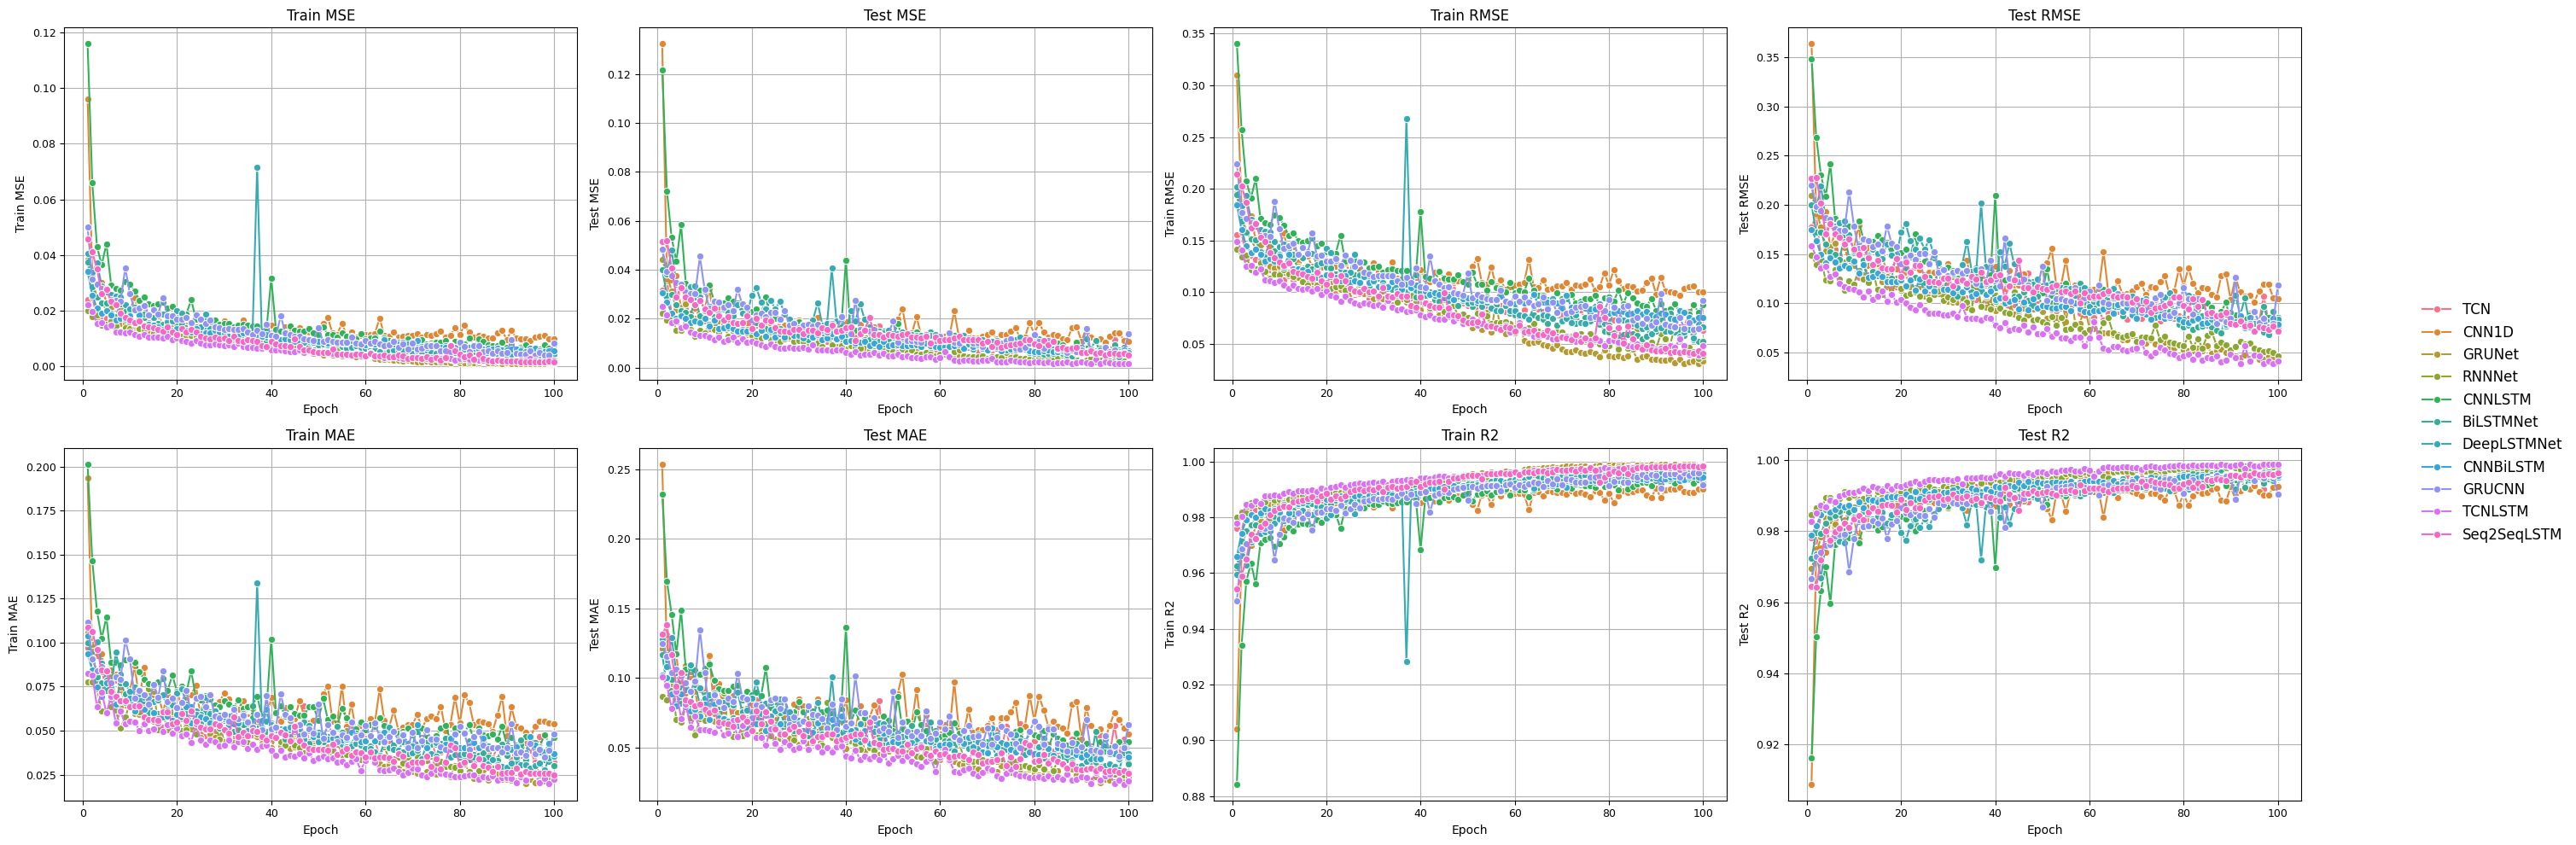

In [28]:
train_figures_ts = {}

models = ["TCN", "CNN1D", "GRUNet", "RNNNet", "CNNLSTM", "BiLSTMNet", 
          "DeepLSTMNet", "CNNBiLSTM", "GRUCNN", "TCNLSTM", "Seq2SeqLSTM"]

df_models = nn_metrics_ts_df[nn_metrics_ts_df["Model"].isin(models)]

n_metrics = len(metrics_to_plot)
ncols = 4
nrows = (n_metrics + ncols - 1) // ncols  

fig, axes = plt.subplots(nrows, ncols, figsize=(28, 10), sharey=False)
axes = axes.flatten()

handles, labels = None, None

for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]
    sns.lineplot(data=df_models, x="Epoch", y=metric, hue="Model", marker='o', ax=ax)
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("Epoch", fontsize=10)
    ax.set_ylabel(metric, fontsize=10)
    ax.grid(True)
    ax.tick_params(labelsize=9)

    if handles is None and ax.get_legend():
        handles, labels = ax.get_legend_handles_labels()

    if ax.get_legend():
        ax.get_legend().remove()

for j in range(n_metrics, len(axes)):
    fig.delaxes(axes[j])
    
if handles and labels:
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.01, 0.5),
               fontsize="large", frameon=False)

plt.tight_layout(rect=[0, 0, 0.97, 1])  
train_figures_ts["Train_Metrics_TS"] = fig
plt.show()
plt.close()

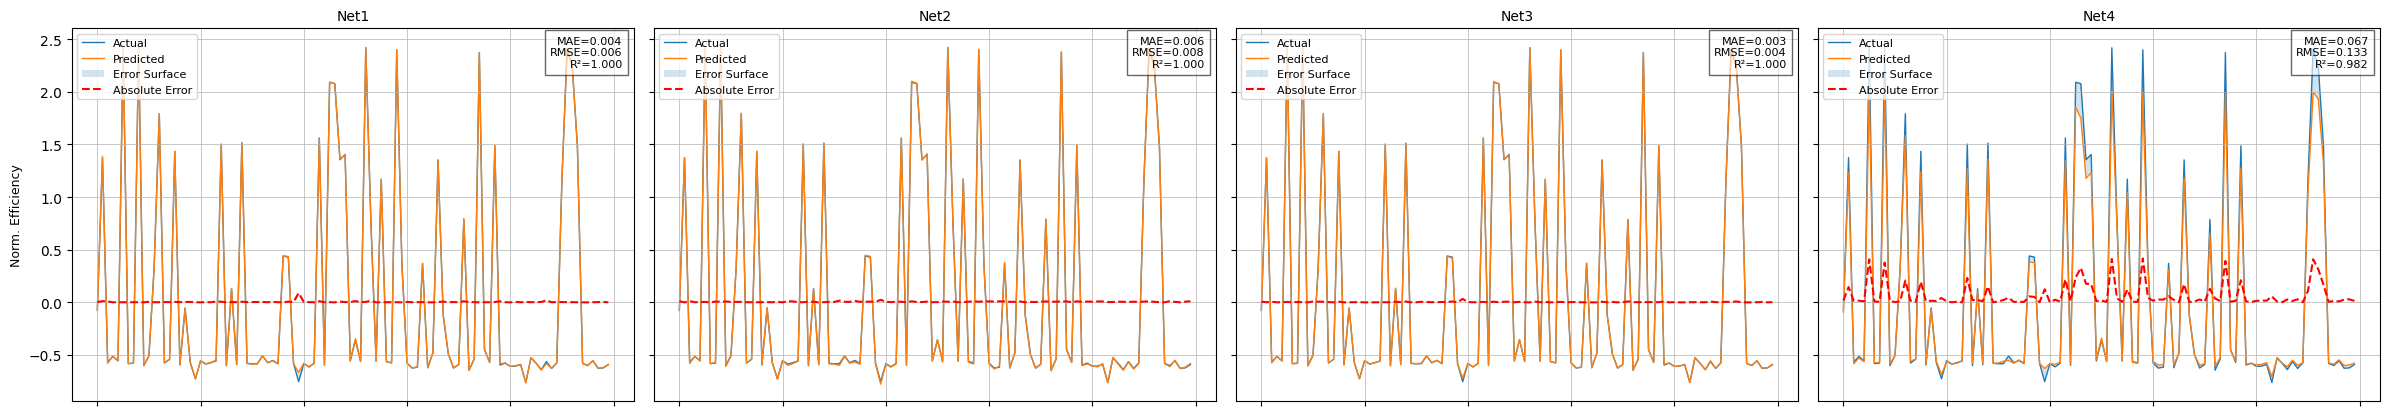

In [29]:
pred_figures_nets = {}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_models = len(nets)
ncols, nrows = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(24, 16),
                         sharex=True, sharey=True)
axes = axes.flatten()

desired = 100   
max_pts = 100

last_row_start = nrows * ncols - ncols
offset = (ncols - n_models % ncols) // 2 if n_models % ncols != 0 else 0

for i, (name, model) in enumerate(nets.items()):
    row = i // ncols
    col = i % ncols
    if row == nrows - 1 and n_models % ncols != 0:
        col += offset
    ax_index = row * ncols + col
    ax = axes[ax_index]

    model = model.to(device).eval()
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(desired, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)

    idx = np.linspace(0, n_samples - 1, min(n_samples, max_pts), dtype=int)

    ax.plot(idx, y_t[idx], label="Actual", lw=1, zorder=1)
    ax.plot(idx, y_p[idx], label="Predicted", lw=1, zorder=1)
    ax.fill_between(idx, y_t[idx], y_p[idx], alpha=0.2, label="Error Surface", zorder=0)
    ax.plot(idx, err[idx], '--', lw=1.5, color='red', label="Absolute Error", zorder=3)

    m = (nn_metrics_df.query("Model == @name").sort_values("Epoch").iloc[-1])
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.98, stats, transform=ax.transAxes,
            ha='right', va='top', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))

    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)

    if col == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    if row == nrows - 1:
        ax.set_xlabel("Sample Index", fontsize=9)

    ax.legend(fontsize=8, loc="upper left")

for j in range(n_models, nrows * ncols):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets["Prediction_Nets"] = fig
plt.show()
plt.close()


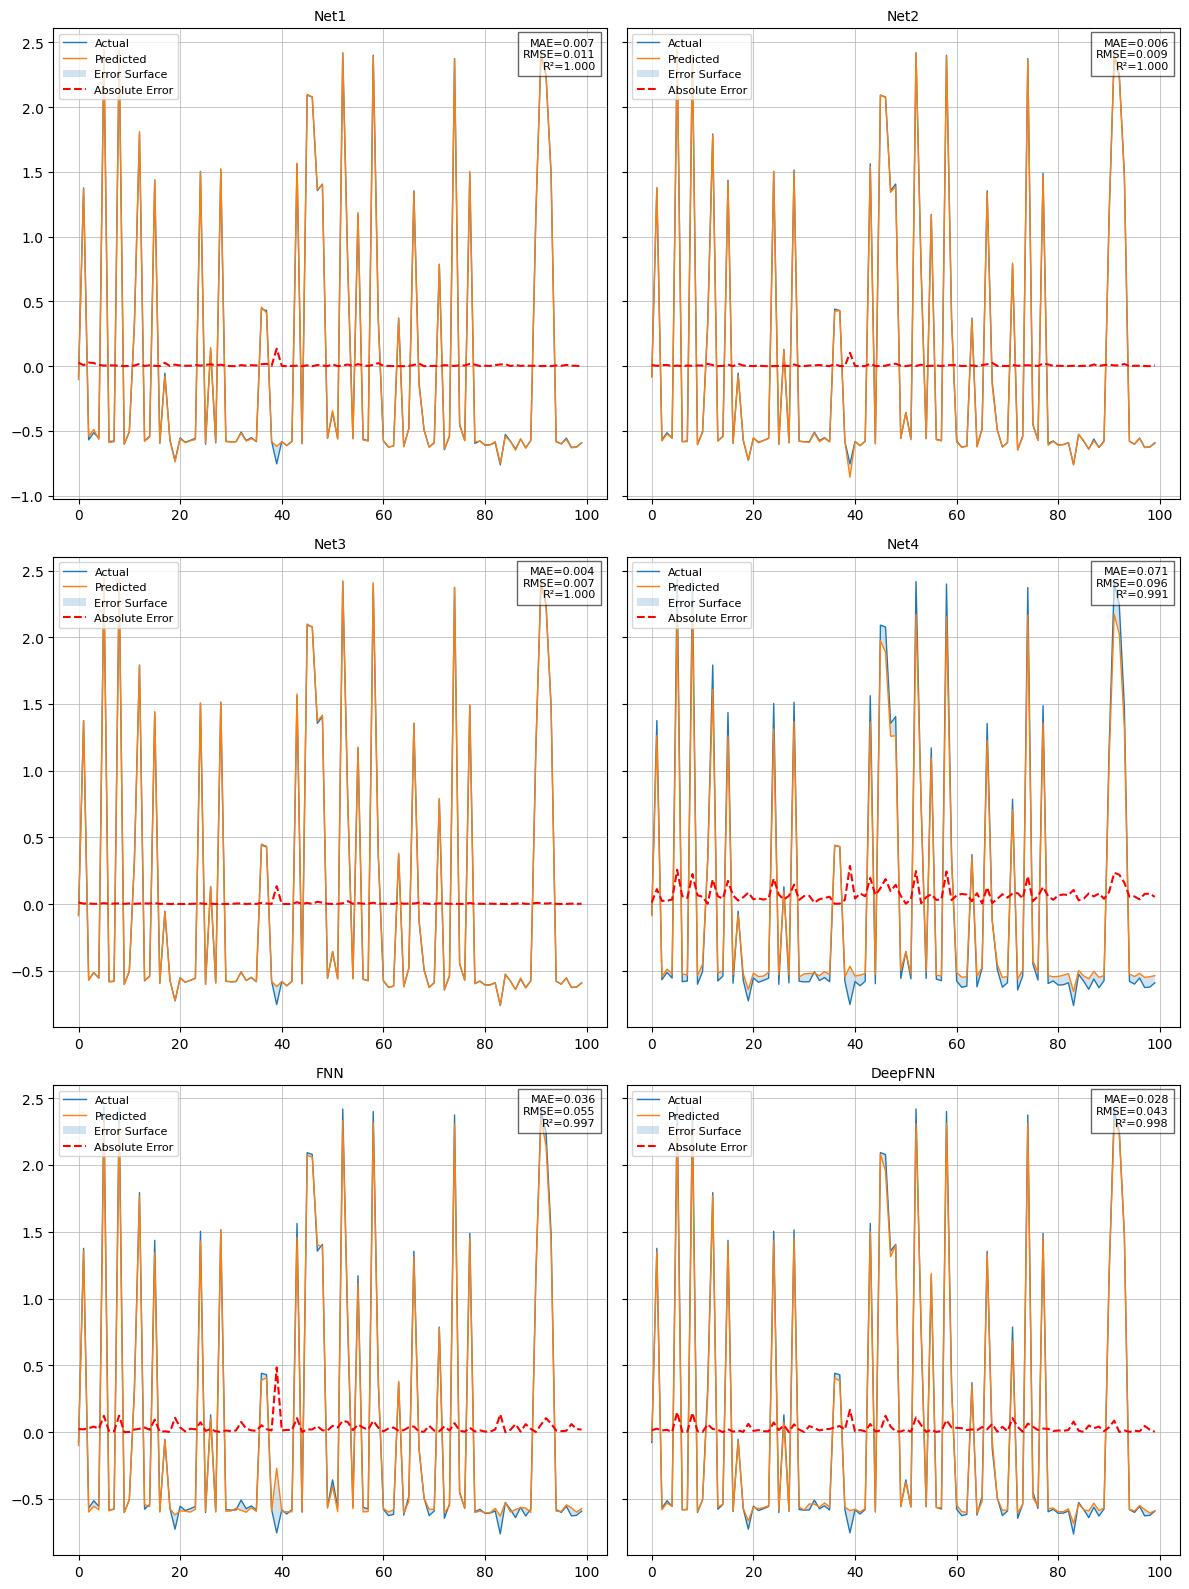

In [30]:
pred_figures_nets_tab = {}

n_models = len(nets_tabular)
nrows, ncols = 3, 2 

fig, axes = plt.subplots(nrows, ncols, figsize=(12, 16), sharey='row')
axes = axes.flatten()

model_items = list(nets_tabular.items())

for i, (name, model) in enumerate(model_items):
    ax = axes[i]
    model = model.to(device).eval()
    
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()

    avail = trues.shape[0]
    n_samples = min(100, avail)
    y_t = trues[-n_samples:]
    y_p = preds[-n_samples:]
    err = np.abs(y_t - y_p)
    idx = np.linspace(0, n_samples - 1, min(n_samples, 100), dtype=int)

    ax.plot(idx, y_t[idx], label="Actual", lw=1)
    ax.plot(idx, y_p[idx], label="Predicted", lw=1)
    ax.fill_between(idx, y_t[idx], y_p[idx], alpha=0.2, label="Error Surface")
    ax.plot(idx, err[idx], '--', lw=1.5, color='red', label="Absolute Error")

    m = nn_metrics_df_tabular.query("Model == @name").sort_values("Epoch").iloc[-1]
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.98, stats, transform=ax.transAxes,
            ha='right', va='top', fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))
    ax.set_title(name, fontsize=10)
    ax.grid(True, linewidth=0.5)
    ax.legend(fontsize=8, loc="upper left")

for j in range(len(model_items), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
pred_figures_nets_tab["Prediction_Nets_Tab"] = fig
plt.show()
plt.close()

/var/folders/x0/t4xvycdd6mz7b1y2rk0pl9mw0000gn/T/ipykernel_9433/781045368.py:60: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()
/var/folders/x0/t4xvycdd6mz7b1y2rk0pl9mw0000gn/T/ipykernel_9433/781045368.py:60: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


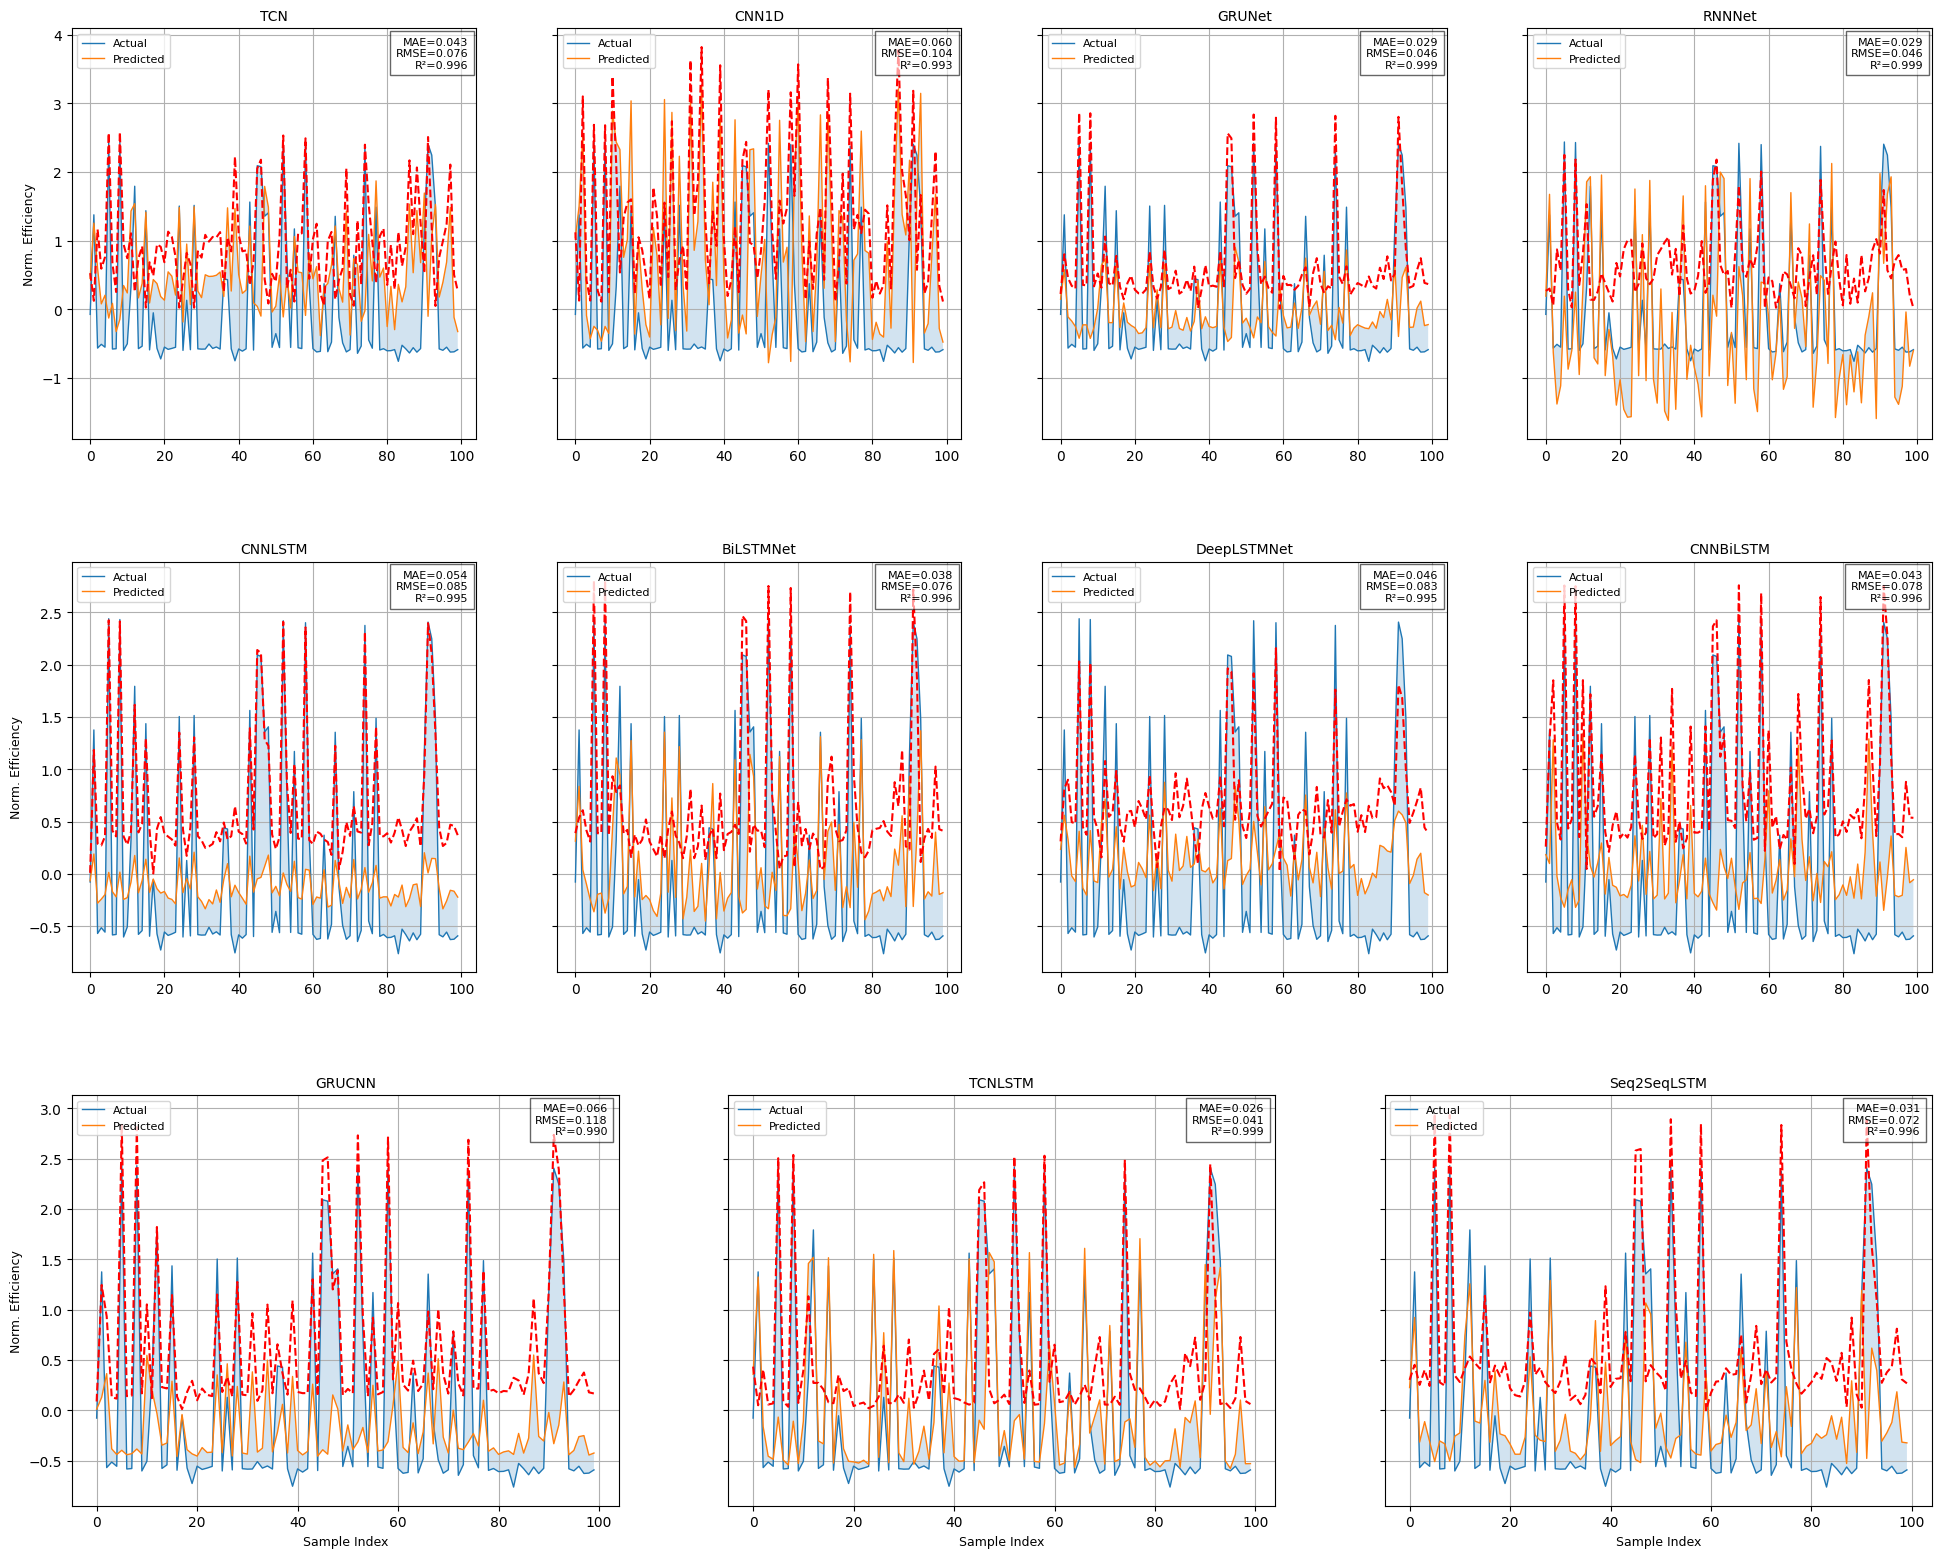

In [70]:
pred_figures_nets_ts = {}
n_models = len(ts_nets)
ncols = 4
full_rows = n_models // ncols   
remainder = n_models % ncols

fig = plt.figure(constrained_layout=True,
                 figsize=(24, 16))
subfigs = fig.subfigures(full_rows + 1, 1,
                         height_ratios=[1]*full_rows + [1])

def plot_model(ax, name, model):
    model = model.to(device).eval()
    with torch.no_grad():
        X_in = reshape_input(model, X_test_tensor.to(device))
        preds = model(X_in).cpu().numpy().flatten()
        trues = y_test_tensor.cpu().numpy().flatten()
    n = min(100, len(trues))
    idxs = np.linspace(0, n - 1, min(n, 100), dtype=int)
    y_t, y_p = trues[-n:][idxs], preds[-n:][idxs]
    err = np.abs(y_t - y_p)
    ax.plot(idxs, y_t, label="Actual", lw=1)
    ax.plot(idxs, y_p, label="Predicted", lw=1)
    ax.fill_between(idxs, y_t, y_p, alpha=0.2)
    ax.plot(idxs, err, '--', lw=1.5, color='red')
    m = nn_metrics_ts_df.query("Model == @name") \
                        .sort_values("Epoch") \
                        .iloc[-1]
    stats = f"MAE={m['Test MAE']:.3f}\nRMSE={m['Test RMSE']:.3f}\nR²={m['Test R2']:.3f}"
    ax.text(0.98, 0.98, stats,
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=8,
            bbox=dict(facecolor='white', alpha=0.6))
    ax.set_title(name, fontsize=10)
    ax.grid(True)
    ax.legend(fontsize=8, loc="upper left")

for i in range(full_rows):
    axs = subfigs[i].subplots(1, ncols,
                              sharex=True,
                              sharey=True)
    for ax, (name, model) in zip(axs, list(ts_nets.items())[i * ncols:(i + 1) * ncols]):
        plot_model(ax, name, model)
    for ax in axs:
        if axs.tolist().index(ax) == 0:
            ax.set_ylabel("Norm. Efficiency", fontsize=9)
        if i == full_rows: 
            ax.set_xlabel("Sample Index", fontsize=9)

axs_last = subfigs[full_rows].subplots(1, remainder,
                                        sharex=True,
                                        sharey=True)
for ax, (name, model) in zip(axs_last, list(ts_nets.items())[full_rows * ncols :]):
    plot_model(ax, name, model)
    if axs_last.tolist().index(ax) == 0:
        ax.set_ylabel("Norm. Efficiency", fontsize=9)
    ax.set_xlabel("Sample Index", fontsize=9)

plt.tight_layout()
pred_figures_nets_ts["Prediction_Nets_TS"] = fig
plt.show()
plt.close()

In [65]:
save_ml_experiment(
    station="Global",
    results=results,
    y_test=y_test,
    metrics_df=metrics_df,
    table_fig=table_fig,
    barplot_fig=barplot_fig,
    pred_figs=pred_figs,
    models_dict=models,
    base_dir=Path("..")
)

In [66]:
for name, model in nets.items():
    save_experiment(
        station="Global",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df[nn_metrics_df["Model"] == name],
        train_figs=train_figures,
        pred_figs=pred_figures_nets,
        base_dir=Path("..")
    )

In [67]:
for name, model in nets_tabular.items():
    save_experiment(
        station="Global",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_df_tabular[nn_metrics_df_tabular["Model"] == name],
        train_figs=train_figures_tabular,
        pred_figs= pred_figures_nets_tab,
        base_dir=Path("..")
    )

In [71]:
for name, model in ts_nets.items():
    save_experiment(
        station="Global",
        model_name=name,
        net=model,
        metrics_df=nn_metrics_ts_df[nn_metrics_ts_df["Model"] == name],
        train_figs=train_figures_ts,
        pred_figs=pred_figures_nets_ts,
        base_dir=Path("..")
    )